In [1]:
import ROOT
import math
from array import array

Welcome to JupyROOT 6.26/00


In [2]:
%%bash
pwd

/Users/akhanal/work/Expt_phys/simulation/xi_1820/test


In [3]:
fc = """
void MyFeldmanCousins(Double_t obs, Double_t bg){
   if (!gROOT->GetClass("TFeldmanCousins"))
      R__LOAD_LIBRARY(libPhysics);

   TFeldmanCousins f;

   // calculate either the upper or lower limit for 10 observed
   // events with an estimated background of 3.  The calculation of
   // either upper or lower limit will return that limit and fill
   // data members with both the upper and lower limit for you.
   Double_t Nobserved   = obs;   //10.0;
   Double_t Nbackground = bg;    //3.0;

   Double_t ul = f.CalculateUpperLimit(Nobserved, Nbackground);
   Double_t ll = f.GetLowerLimit();

   cout << "For " <<  Nobserved << " data observed with and estimated background"<<endl;
   cout << "of " << Nbackground << " candidates, the Feldman-Cousins method of "<<endl;
   cout << "calculating confidence limits gives:"<<endl;
   cout << "\tUpper Limit = " <<  ul << endl;
   cout << "\tLower Limit = " <<  ll << endl;
   cout << "at the 90% CL"<< endl;
}
"""

**Declare cpp Feldman Cousins macro using ROOT.gInterpreter.Declare()**

In [4]:
ROOT.gInterpreter.Declare(fc) 

True

In [5]:
ls -l *.root

-rw-r--r--  1 akhanal  staff       44490 Feb 13  2022 basic.root
-rw-r--r--  1 akhanal  staff      890817 Feb 22  2022 data_all_fde.root
-rw-r--r--  1 akhanal  staff     7487446 Feb 22  2022 data_all_fte.root
-rw-r--r--  1 akhanal  staff     7391613 Feb 22  2022 data_all_fte_ecornonly.root
-rw-r--r--  1 akhanal  staff     7233824 Feb 22  2022 data_all_fte_nocorn.root
-rw-r--r--  1 akhanal  staff      243193 Feb 21  2022 data_fall2018_in_fde.root
-rw-r--r--  1 akhanal  staff      256433 Jun 16 22:29 data_fall2018_in_fde_goodruns.root
-rw-r--r--  1 akhanal  staff      273170 Jul 28 18:57 data_fall2018_in_fde_goodruns_hasLamSigWeight.root
-rw-r--r--  1 akhanal  staff   511797782 Oct  4 12:13 data_fall2018_in_fde_goodruns_mixEv_ekm_fkp_skp.root
-rw-r--r--  1 akhanal  staff   202574473 Jul 28 16:37 data_fall2018_in_fde_goodruns_threeKaon_mixEv_bg.root
-rw-r--r--  1 akhanal  staff     3130991 Feb 22  2022 data_fall2018_in_fte.root
-rw-r--r--  1 akhanal  staff     3090975 Feb 22  2022 data_fa

In [6]:
ls -l data_fall2018_out_fde.root

-rw-r--r--  1 akhanal  staff  422232 Feb 22  2022 data_fall2018_out_fde.root


In [7]:
%%bash
rootls -l data_fall2018_out_fde.root

TTree  Feb 22 16:18 2022 T;1 "data from ascii file" 


**Print ROOT File variables using RDataFrame**

In [8]:
data_tree = "T"
gen_mctree = "T"
rec_mctree = "T"
#data_file = "data_fall2018_out_fde_goodruns_mixEv_bg.root"
data_file = "data_fall2018_out_fde_goodruns_threeKaon_mixEv_bg1.root"
gen_mcfile = "mc_gen_fall2018_out_fde.root"
rec_mcfile = "mc_rec_fall2018_out_fde.root"
df = ROOT.RDataFrame(data_tree, data_file)
genmcdf = ROOT.RDataFrame(gen_mctree, gen_mcfile)
recmcdf = ROOT.RDataFrame(rec_mctree, rec_mcfile)
print(f"Columns in the dataset: {df.GetColumnNames()}")
#print(f"Columns in the dataset: {genmcdf.GetColumnNames()}")
#print(f"Columns in the dataset: {recmcdf.GetColumnNames()}")

Columns in the dataset: { "mm_fkpskp_mixed", "mm_fkpskpkm_mixed" }


In [9]:
%%cpp 
double background(Double_t *x, Double_t *par) {
  return par[0] + par[1]*x[0];
}

In [10]:
%%cpp
Double_t p2background(Double_t *x, Double_t *par) {
  //return par[0] + par[1]*x[0] + par[2]*x[0]*x[0]+ par[3]*x[0]*x[0]*x[0];
  return par[0] + par[1]*x[0] + par[2]*x[0]*x[0];
}

In [11]:
%%cpp
Double_t p3background(Double_t *x, Double_t *par) {
  return par[0] + par[1]*x[0] + par[2]*x[0]*x[0]+ par[3]*x[0]*x[0]*x[0];
  
}

In [12]:
%%cpp 
double backgroundPoly(Double_t *x) {
  return 2*x[0]*x[0]-1;
}

In [13]:
%%cpp
Double_t Gaussian(Double_t *x, Double_t *par)
{
    Double_t arg = 0;
    if (par[2]) arg = (x[0] - par[1])/par[2];
    Double_t sig = par[0]*TMath::Exp(-0.5*arg*arg);
    return sig;
}

In [14]:
%%cpp
Double_t GaussianPeak(Double_t *x, Double_t *par)
{
    Double_t arg = 0;
    if (par[2]) arg = (x[0] - par[1])/par[2];
    Double_t sig = par[0]*TMath::Exp(-0.5*arg*arg);
    return sig;
}

In [15]:
%%cpp
double p2fitDoubleGaus(double *x, double *par) {
  return GaussianPeak(x, par) + Gaussian(x, &par[3]) + p2background(x, &par[6]);
}

In [16]:
%%cpp
double fitDoubleGaus(double *x, double *par) {
  return GaussianPeak(x, par) + Gaussian(x, &par[3]) + background(x, &par[6]);
}

In [17]:
%%cpp
double fitGaus(double *x, double *par) {
  return GaussianPeak(x, par) + p2background(x, &par[3]);
}

In [18]:
%%cpp
double fitp3Gaus(double *x, double *par) {
  return GaussianPeak(x, par) + p3background(x, &par[3])*par[7];
    //+ par[3]+par[4]*x[0]+par[5]*x[0]*x[0]+par[6]*x[0]*x[0]*x[0];
}

In [19]:
%%cpp
Double_t lorentzianPeak(Double_t *x, Double_t *par) {
    return (0.5*par[0]*par[2]/TMath::Pi()) /
    TMath::Max( 1.e-10,
               (x[0]-par[1])*(x[0]-par[1]) + .25*par[2]*par[2]
               );
}

In [20]:
%%cpp
Double_t fitLorentzianPeak(Double_t *x, Double_t *par) {
    return lorentzianPeak(x, par) + p2background(x, &par[3]);
    //return lorentzianPeak(x, par) + backgroundPoly(x);
}

In [21]:
%%cpp
double fitBW(double *x, double *par) {
  return lorentzianPeak(x, par) + background(x, &par[3]);
}

In [22]:
%%cpp
float low_3sigma(TF1 *fcn){
    return fcn->GetParameter(1)-3*fcn->GetParameter(2);
}

In [23]:
%%cpp
float high_3sigma(TF1 *fcn){
    return fcn->GetParameter(4)+3*fcn->GetParameter(5);
}

In [24]:
%%cpp
bool sigmaCut(TF1 *fcn){
    if(fcn->GetParameter(1)-3*fcn->GetParameter(2) && fcn->GetParameter(4)+3*fcn->GetParameter(5)){
        return true;
    }
    else {
        return false;
    }  
}

## Background Shape modeling
* **To model a background shape, implemented events mixing technique in $eK^{+}K^{+}K^{-}$ data sample**

In [25]:
#h1 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_mixEv_all.root").Histo1D(("data-mixev", "data-mixev", 200, 0, 2), "mm_fkpskpkm_mixed")
#h1 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_mixEv_bg.root").Histo1D(("data-mixev", "data-mixev", 200, 0, 2), "mm_fkpskpkm_mixed")
#h1 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_mixEv_bg.root").Histo1D(("data-mixev", "data-mixev", 200, 0, 2), "mm_fkpskpkm_mixed")
h1 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_mixEv_ekm_fkp_skp.root").Histo1D(("data-mixev", "data-mixev", 200, 0, 2), "mm_fkpskpkm_mixed")
#h1 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_threeKaon_mixEv_bg1.root").Histo1D(("data-mixev", "data-mixev", 200, 0.5, 1.8), "mm_fkpskpkm_mixed")
#h1 = ROOT.RDataFrame("T","data_fall2018_in_fde_goodruns_threeKaon_mixEv_bg.root").Histo1D(("data-mixev", "data-mixev", 200, 0.5, 1.8), "mm_fkpskpkm_mixed")
#h1 = ROOT.RDataFrame("T","data_spring2019_in_fde_goodruns_threeKaon_mixEv_bg.root").Histo1D(("data-mixev", "data-mixev", 200, 0.5, 1.8), "mm_fkpskpkm_mixed")

#h1.SetTitle("MM(eK^{+}K^{+}K^{-})-Bg. Modeling using events mixing")#58, 0.87, 1.45#50, 0.9, 1.4#200, 0, 2
h1.SetTitle("")
#h1.SetTitleSize(0.06, "x")
h1.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
h1.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
h1.GetXaxis().SetTitleSize(0.05)
h1.GetYaxis().SetTitleSize(0.05)
h1.GetXaxis().SetTitleOffset(0.9)
#h1.GetYaxis().SetTitleOffset(0.9)

#bg_fn = ROOT.TF1("bg_fn", "pol3+landau(4)", 1.0, 2.8, 7)
#bg_fn = ROOT.TF1("bg_fn", "landau", 1.0, 2.8, 3)
#bg_fn = ROOT.TF1("bg_fn", "pol1", 0.4, 2.0, 2)
#bg_fn = ROOT.TF1("bg_fn", "pol2", 0.9, 1.4, 3)
bg_fn = ROOT.TF1("bg_fn", "pol3", 0.4, 2.0, 4)

hmixev_cut = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_mixEv_ekm_fkp_skp.root").Filter("1.07<=mm_fkpskpkm_mixed && mm_fkpskpkm_mixed<=1.25").Histo1D(("bg-mixev","bg-mixev", 200, 0, 2), "mm_fkpskpkm_mixed") #100, 0.0, 2.4 #25, 0.5, 2.0
hmixev_cut.SetTitle("MM(eK^{+}K^{+}K^{-})")
#h1.SetTitleSize(0.06, "x")
hmixev_cut.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
hmixev_cut.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
hmixev_cut.GetXaxis().SetTitleSize(0.05)
hmixev_cut.GetYaxis().SetTitleSize(0.05)
hmixev_cut.GetXaxis().SetTitleOffset(0.9)
hmixev_cut.GetYaxis().SetTitleOffset(0.9)
hmixev_cut.SetFillStyle(3004)
hmixev_cut.SetFillColor(ROOT.kMagenta)

%jsroot on
ROOT.gStyle.SetOptStat(0000)
ROOT.gStyle.SetOptFit(1)
c = ROOT.TCanvas()
h1.Draw("E")
#hmixev_cut.Draw("same")
h1.SetLineColor(ROOT.kRed)
h1.SetMarkerStyle(21)
h1.SetMarkerSize(0.8)
#bg_fitResult = h1.Fit("pol3", "EMS"," ", 0.4,2.0)
threeKaonBg_fitResult = h1.Fit(bg_fn, "LEMS"," ", 0.4,1.4)

c.Draw()

 FCN=391.259 FROM MINOS     STATUS=SUCCESSFUL     70 CALLS         717 TOTAL
                     EDM=1.21018e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.58751e+04   9.54120e+02  -3.84293e-01  -4.32721e-07
   2  p1          -1.34715e+05   3.73010e+03   1.60098e+00  -4.72060e-07
   3  p2           3.37370e+05   4.53787e+03  -1.45083e+00  -5.44085e-07
   4  p3          -1.30664e+05   1.73283e+03   1.73283e+03  -5.97808e-06
                               ERR DEF= 0.5


##  **Background + Signal Fit**
* **Used double gaussian function to fit $\Lambda$ and $\Sigma0$ signal in the $MM(eK^{+}K^{+}K^{-})$ spectra**
* **For the background, used background template derived using event mixing technique over $eK^{+}K^{+}K^{-}$ data sample in the previous step** 
## MM-Fit function = gaus($\Lambda$-template) + gaus($\Sigma0$-template) + C*(bg-model-from-Event-Mixing)

In [26]:
h1 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns.root").Histo1D(("data","data", 200, 0, 2), "mm_fkpskpkm") #100, 0.0, 2.4 #25, 0.5, 2.0
h1.SetTitle("MM(eK^{+}K^{+}K^{-})")#58, 0.87, 1.45#50, 0.9, 1.4
#h1.SetTitleSize(0.06, "x")
h1.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
h1.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
h1.GetXaxis().SetTitleSize(0.05)
h1.GetYaxis().SetTitleSize(0.05)
h1.GetXaxis().SetTitleOffset(0.9)
#h1.GetYaxis().SetTitleOffset(0.9)
%jsroot on
ROOT.gStyle.SetOptStat(00000)
ROOT.gStyle.SetOptFit(1)
c = ROOT.TCanvas()
h1.Draw("E")
h1.SetLineColor(ROOT.kRed)
h1.SetMarkerStyle(21)
h1.SetMarkerSize(0.8)
#fitFcn = ROOT.TF1("fitFcn", ROOT.p3fitDoubleGaus, 0.5, 2.0, 11)
fitFcn_test = ROOT.TF1("fitFcn_test", "gaus(0)+gaus(3)+(pol3(6)*pol0(10))", 0.5, 2.0, 11)
fitFcn_test.SetLineColor(ROOT.kMagenta)
fitFcn_test.SetParameter(0, h1.GetBinContent(h1.GetMaximumBin())) #peak h1.GetBinContent(h1.GetMaximumBin())
fitFcn_test.SetParLimits(0, h1.GetBinContent(h1.GetMaximumBin())-10, h1.GetBinContent(h1.GetMaximumBin())+5)
fitFcn_test.SetParameter(1, 1.115683) #mean h1.GetBinCenter(h1.GetMaximumBin())#1.115683
fitFcn_test.SetParLimits(1, 1.09, 1.13)
fitFcn_test.SetParameter(2, 0.04) #sigma
fitFcn_test.SetParLimits(2, 0.01, 0.06)
fitFcn_test.SetParameter(3, h1.GetBinContent(h1.GetMaximumBin())) #peak
fitFcn_test.SetParLimits(3, h1.GetBinContent(h1.GetMaximumBin())-25, h1.GetBinContent(h1.GetMaximumBin())-15)
fitFcn_test.SetParameter(4, 1.192642) #mean#1.192642
fitFcn_test.SetParLimits(4, 1.15, 1.24)
fitFcn_test.SetParameter(5, 0.04) #sigma
fitFcn_test.SetParLimits(5, 0.01, 0.07)
fitFcn_test.FixParameter(6, bg_fn.GetParameter(0))
fitFcn_test.FixParameter(7, bg_fn.GetParameter(1))
fitFcn_test.FixParameter(8, bg_fn.GetParameter(2))
fitFcn_test.FixParameter(9, bg_fn.GetParameter(3))
fitFcn_test.SetParameter(10, 0.002)
#h1.Fit(fitFcn_test, "LEMS","",0.8,2.1)0.9,1.4
h1.Fit(fitFcn_test, "LEMS","",0.9,1.4)

#improve the picture:
backFcn_test = ROOT.TF1("backFcn_test", "pol3(0)*pol0(4)", 0.9, 1.4, 2)
backFcn_test.SetParameters(fitFcn_test.GetParameter(6), fitFcn_test.GetParameter(7), fitFcn_test.GetParameter(8), fitFcn_test.GetParameter(9), fitFcn_test.GetParameter(10))
#backFcn_test = ROOT.TF1("backFcn_test", ROOT.p2background, 0.9, 1.4, 3)
#backFcn_test.SetParameters(fitFcn_test.GetParameter(6), fitFcn.GetParameter(7), fitFcn.GetParameter(8))
backFcn_test.SetLineColor(ROOT.kRed)
backFcn_test.SetLineStyle(7)
lamSignalFcn_test = ROOT.TF1("lamSignalFcn_test", "gaus", 0.9, 1.4, 3)
lamSignalFcn_test.SetParameters(fitFcn_test.GetParameter(0), fitFcn_test.GetParameter(1), fitFcn_test.GetParameter(2))
lamSignalFcn_test.SetLineColor(ROOT.kBlue)#ROOT.kGreen
sigSignalFcn_test = ROOT.TF1("sigSignalFcn_test", "gaus", 0.9, 1.4, 3)
sigSignalFcn_test.SetParameters(fitFcn_test.GetParameter(3), fitFcn_test.GetParameter(4), fitFcn_test.GetParameter(5))
sigSignalFcn_test.SetLineColor(ROOT.kGreen)#ROOT.kBlue
#signalFcn.SetNpx(500)
#'''
fitFcn_test.Draw("same")
backFcn_test.Draw("same")
lamSignalFcn_test.Draw("same")
sigSignalFcn_test.Draw("same")
#'''
c.Draw()

 FCN=31.8291 FROM MINOS     STATUS=SUCCESSFUL    148 CALLS        3035 TOTAL
                     EDM=2.95961e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.11540e+01   3.14579e+00   1.89198e-03   4.92722e-04
   2  p1           1.12936e+00   3.03231e-03   9.31949e-04  -5.36063e-04
   3  p2           2.01691e-02   2.40001e-03  -9.32123e-05  -1.81188e-03
   4  p3           1.50000e+01   6.24045e+00  -1.02514e-06** at limit **
   5  p4           1.19965e+00   5.23781e-03   1.80091e-04   3.52742e-03
   6  p5           1.98769e-02   4.70472e-03  -1.42180e-03  -2.13048e-03
   7  p6           4.58751e+04     fixed    
   8  p7          -1.34715e+05     fixed    
   9  p8           3.37370e+05     fixed    
  10  p9          -1.30664e+05     fixed    
  11  p10          4.43285e-05   3.23154e-06   3.23154e-06   7.26236e+01
        

Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 


## Evaluate gaus($\Lambda$), gaus($\Sigma0$),  bg fit functions and calculate corresponding probabilities (function of $MM(K^{+}K^{+}K^{-}$) event by event 

In [27]:
### Bin Size ####
#25, 1.5, 2.5 -> 40 MeV -> [1.780, 1.820) 
#25, 1.520, 2.520 -> 40MeV -> [1.800, 1.840)


#bg_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29").Histo1D(("bg-data", "bg-data", 25, 1.5, 2.5), "mm_fkpskp", "w_bg")
#bg_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight_v1.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29").Histo1D(("bg-data", "bg-data", 25, 1.520, 2.520), "mm_fkpskp", "w_bg")
#bg_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight_v1.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29").Histo1D(("bg-data", "bg-data", 25, 1.5, 2.5), "mm_fkpskp", "w_bg")
bg_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight1.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29").Histo1D(("bg-data", "bg-data", 25, 1.5, 2.5), "mm_fkpskp", "w_bg")
bg_histo.Sumw2()
bg_histo.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
bg_histo.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
#bg_histo.GetYaxis().SetTitleOffset(0.9)
bg_histo.GetXaxis().SetTitleSize(0.05)
bg_histo.GetYaxis().SetTitleSize(0.05)
bg_histo.GetXaxis().SetTitleOffset(0.9)
#bg_histo.GetYaxis().SetTitleOffset(0.9)
bg_histo.SetLineColor(ROOT.kRed)
bg_histo.SetMarkerColor(ROOT.kRed)
bg_histo.SetMarkerStyle(21)
bg_histo.SetMarkerSize(0.8)

#lam_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29").Histo1D(("lam-data", "lam-data", 25, 1.5, 2.5), "mm_fkpskp", "w_lam")
#lam_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight_v1.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29").Histo1D(("lam-data", "lam-data", 25, 1.520, 2.520), "mm_fkpskp", "w_lam")
#lam_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight_v1.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29").Histo1D(("lam-data", "lam-data", 25, 1.5, 2.5), "mm_fkpskp", "w_lam")
lam_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight1.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29&& (m_fkpkm > 1.08 || m_skpkm > 1.08)").Histo1D(("lam-data", "lam-data", 25, 1.5, 2.5), "mm_fkpskp", "w_lam")
lam_histo.Sumw2()
lam_histo.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
lam_histo.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
#lam_histo.GetYaxis().SetTitleOffset(0.9)
lam_histo.GetXaxis().SetTitleSize(0.05)
lam_histo.GetYaxis().SetTitleSize(0.05)
lam_histo.GetXaxis().SetTitleOffset(0.9)
#lam_histo.GetYaxis().SetTitleOffset(0.9)
lam_histo.SetLineColor(ROOT.kCyan)
lam_histo.SetMarkerColor(ROOT.kCyan)
lam_histo.SetMarkerStyle(20)
lam_histo.SetMarkerSize(0.8)

#sig_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29").Histo1D(("sig-data", "sig-data", 25, 1.5, 2.5), "mm_fkpskp", "w_sig")
#sig_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight_v1.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29").Histo1D(("sig-data", "sig-data", 25, 1.520, 2.520), "mm_fkpskp", "w_sig")
#sig_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight_v1.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29").Histo1D(("sig-data", "sig-data", 25, 1.5, 2.5), "mm_fkpskp", "w_sig")
sig_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight1.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29&& (m_fkpkm > 1.08 || m_skpkm > 1.08)").Histo1D(("sig-data", "sig-data", 25, 1.5, 2.5), "mm_fkpskp", "w_sig")
sig_histo.Sumw2()
sig_histo.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
sig_histo.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
#sig_histo.GetYaxis().SetTitleOffset(0.9)
sig_histo.GetXaxis().SetTitleSize(0.05)
sig_histo.GetYaxis().SetTitleSize(0.05)
sig_histo.GetXaxis().SetTitleOffset(0.9)
#sig_histo.GetYaxis().SetTitleOffset(0.9)
sig_histo.SetLineColor(ROOT.kOrange) #ROOT.kGreen+10
sig_histo.SetMarkerColor(ROOT.kOrange)
sig_histo.SetMarkerStyle(20)
sig_histo.SetMarkerSize(0.8)


lamsig_histo = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_hasLamSigWeight1.root").Filter("1.00<=mm_fkpskpkm && mm_fkpskpkm<=1.29&& (m_fkpkm > 1.08 || m_skpkm > 1.08)").Histo1D(("lamsig-data", "lamsig-data", 25, 1.5, 2.5), "mm_fkpskp", "w_lamsig")
lamsig_histo.Sumw2()
lamsig_histo.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
lamsig_histo.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
#lamsig_histo.GetYaxis().SetTitleOffset(0.9)
lamsig_histo.GetXaxis().SetTitleSize(0.05)
lamsig_histo.GetYaxis().SetTitleSize(0.05)
lamsig_histo.GetXaxis().SetTitleOffset(0.9)
#lamsig_histo.GetYaxis().SetTitleOffset(0.9)
lamsig_histo.SetLineColor(ROOT.kMagenta)
lamsig_histo.SetMarkerColor(ROOT.kMagenta)
lamsig_histo.SetMarkerStyle(20)
lamsig_histo.SetMarkerSize(0.8)



%jsroot on
ROOT.gStyle.SetOptStat(00000)
ROOT.gStyle.SetOptFit(0)
c = ROOT.TCanvas()
lamsig_histo.Draw()
lam_histo.Draw("same")
sig_histo.Draw("same")
bg_histo.Draw("same")
c.Draw()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


## MM-Fit function = gaus($\Lambda$) + gaus($\Sigma0$) + bg-poly

In [28]:
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p35p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data","data", 50, 0.9, 1.4), "mm_fkpskpkm") #100, 0.0, 2.4 #25, 0.5, 2.0
h1 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns.root").Histo1D(("data","data", 50, 0.9, 1.4), "mm_fkpskpkm")
#100, 0.5, 2.0 #50, 0.5, 2.0
h1.SetTitle("MM(eK^{+}K^{+}K^{-})")#54, 0.9, 1.44#50, 0.9, 1.4
#h1.SetTitleSize(0.06, "x")
h1.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
h1.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
#h2 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data", "data", 50, 1.5, 3.5), "mm_fkpskp")#50, 1.5, 3.5
h2 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns.root").Histo1D(("data", "data", 50, 1.5, 3.5), "mm_fkpskp")#50, 1.5, 3.5
h2.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h2.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")

h1.GetXaxis().SetTitleSize(0.05)
h1.GetYaxis().SetTitleSize(0.05)
h1.GetXaxis().SetTitleOffset(0.9)
#h1.GetYaxis().SetTitleOffset(0.9)
h2.GetXaxis().SetTitleSize(0.05)
h2.GetYaxis().SetTitleSize(0.05)
h2.GetXaxis().SetTitleOffset(0.9)
#h2.GetYaxis().SetTitleOffset(0.9)

%jsroot on
ROOT.gStyle.SetOptStat(00000)
ROOT.gStyle.SetOptFit(0)
c = ROOT.TCanvas()
c.Divide(1,3)
c.cd(1)
h1.Draw("E")
h1.SetLineColor(ROOT.kRed)
h1.SetMarkerStyle(21)
h1.SetMarkerSize(0.8)
#h1.SetStats(0)


#Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481")
#h1_cut = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("1.0668<=mm_fkpskpkm && mm_fkpskpkm<=1.2491").Histo1D(("da","da", 54, 0.9, 1.44), "mm_fkpskpkm") #100, 0.0, 2.4 #25, 0.5, 2.0
h1_cut = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns.root").Filter("(1.07<=mm_fkpskpkm && mm_fkpskpkm<=1.25)").Histo1D(("da","da", 54, 0.9, 1.44), "mm_fkpskpkm") #100, 0.0, 2.4 #25, 0.5, 2.0
h1_cut.SetTitle("MM(eK^{+}K^{+}K^{-})")
#h1.SetTitleSize(0.06, "x")
h1_cut.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
h1_cut.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
h1_cut.GetXaxis().SetTitleSize(0.05)
h1_cut.GetYaxis().SetTitleSize(0.05)
h1_cut.GetXaxis().SetTitleOffset(0.9)
h1_cut.GetYaxis().SetTitleOffset(0.9)
h1_cut.SetFillStyle(3004)
h1_cut.SetFillColor(ROOT.kMagenta)
#h1_cut.Draw("same")

#(mulam-6siglam) to (mulam-3siglam)= 1.0041<=mm_fkpskpkm && mm_fkpskpkm<1.0668
#h1_sideband1 =  ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("(1.0041<=mm_fkpskpkm && mm_fkpskpkm<1.0668)").Histo1D(("da-sb1", "d-sb1", 54, 0.9, 1.44), "mm_fkpskpkm")
h1_sideband1 =  ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns.root").Filter("(1.00<=mm_fkpskpkm && mm_fkpskpkm<1.07)").Histo1D(("da-sb1", "d-sb1", 54, 0.9, 1.44), "mm_fkpskpkm")
#h1_sideband1.SetLineColor(ROOT.kGreen)
h1_sideband1.SetFillColor(ROOT.kMagenta)
h1_sideband1.SetFillStyle(3004)
h1_sideband1.GetXaxis().SetTitleSize(0.05)
h1_sideband1.GetYaxis().SetTitleSize(0.05)
h1_sideband1.GetXaxis().SetTitleOffset(0.9)
h1_sideband1.GetYaxis().SetTitleOffset(0.9)
h1_sideband1.Draw("same")

#(musig+3sigsig) to (musig+8sigsig) = 1.2491<mm_fkpskpkm && mm_fkpskpkm<=1.3523
#h1_sideband2 =  ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("(1.2491<mm_fkpskpkm && mm_fkpskpkm<=1.3523)").Histo1D(("da-sb1", "da-sb1", 54, 0.9, 1.44), "mm_fkpskpkm")
h1_sideband2 =  ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns.root").Filter("(1.25<mm_fkpskpkm && mm_fkpskpkm<=1.36)").Histo1D(("da-sb1", "da-sb1", 54, 0.9, 1.44), "mm_fkpskpkm")
#h1_sideband2.SetLineColor(ROOT.kGreen)
h1_sideband2.SetFillColor(ROOT.kMagenta)
h1_sideband2.SetFillStyle(3004)
h1_sideband2.GetXaxis().SetTitleSize(0.05)
h1_sideband2.GetYaxis().SetTitleSize(0.05)
h1_sideband2.GetXaxis().SetTitleOffset(0.9)
h1_sideband2.GetYaxis().SetTitleOffset(0.9)
h1_sideband2.Draw("same")


# fit resonance
#h1_fitFcn = ROOT.TF1('h1_fitFcn', ROOT.fitGaus, 0.0, 2.4, 5)
#fitFcn = ROOT.TF1("fitFcn", ROOT.p2fitDoubleGaus, 0.5, 2.0, 9)
fitFcn = ROOT.TF1("fitFcn", ROOT.fitDoubleGaus, 0.5, 2.0, 8)
fitFcn.SetLineColor(ROOT.kMagenta)#kMagenta#kBlue
#h1_fitFcn = ROOT.TF1('h1_fitFcn', ROOT.fitBW, 0.9, 1.4, 5)
#h1_fitFcn.SetLineWidth(3)
#"""
fitFcn.SetParameter(0, h1.GetBinContent(h1.GetMaximumBin())) #peak h1.GetBinContent(h1.GetMaximumBin())
fitFcn.SetParLimits(0, h1.GetBinContent(h1.GetMaximumBin())-10, h1.GetBinContent(h1.GetMaximumBin())+5)
fitFcn.SetParameter(1, 1.115683) #mean h1.GetBinCenter(h1.GetMaximumBin())#1.115683
fitFcn.SetParLimits(1, 1.09, 1.13)
fitFcn.SetParameter(2, 0.04) #sigma
fitFcn.SetParLimits(2, 0.01, 0.06)
fitFcn.SetParameter(3, h1.GetBinContent(h1.GetMaximumBin())) #peak
fitFcn.SetParLimits(3, h1.GetBinContent(h1.GetMaximumBin())-25, h1.GetBinContent(h1.GetMaximumBin())-15)
fitFcn.SetParameter(4, 1.192642) #mean#1.192642
fitFcn.SetParLimits(4, 1.15, 1.24)
fitFcn.SetParameter(5, 0.04) #sigma
fitFcn.SetParLimits(5, 0.01, 0.07)
fitFcn.SetParameter(6, 0.2) #p0
#fitFcn.SetParLimits(6, -2, 0.3)
fitFcn.SetParameter(7, 2.0) #p1(7, 0.6) #p1
#fitFcn.SetParLimits(7, 0.1, 5)
#fitFcn.SetParameter(8, 0) #p2
#fitFcn.SetParLimits(8, -0.2, -10)
#h1_fitFcn.SetParameter(8, -3) #p3
#h1_fitFcn.SetParameter(9, 0.9) #p4
#"""

"""
#BW fit
h1_fitFcn.SetParameter(0, 1.1)
h1_fitFcn.SetParameter(1, 42)
h1_fitFcn.SetParLimits(1, 40, 50)
h1_fitFcn.SetParameter(2, 0.02)
h1_fitFcn.SetParameter(3, 0.06)
h1_fitFcn.SetParameter(4, 0.6)
#"""

#h1.Fit("fitFcn", "EV","",0.9,1.4) # Global Fit
#h1.Fit("fitFcn", "S","",0.9,1.4)
#h1.Fit("h1_fitFcn","V+","ep");
fitResult = h1.Fit("fitFcn", "LEMS","",0.9,1.4)
#h1.Fit("h1_fitFcn","V+","ep");


covMatrix = fitResult.GetCovarianceMatrix()
lamSignalFcn_covMatrix = covMatrix.GetSub(0, 2, 0, 2, " ")
sigSignalFcn_covMatrix = covMatrix.GetSub(3, 5, 3, 5, " ")
bg_covMatrix = covMatrix.GetSub(6, 7, 6, 7, " ")

c.Draw()


#"""
xsq = fitFcn.GetChisquare()
ndf = fitFcn.GetNDF()

chi2perndf = xsq/ndf

#improve the picture:
backFcn = ROOT.TF1("backFcn", ROOT.background, 0.9, 1.4, 2)
backFcn.SetParameters(fitFcn.GetParameter(6), fitFcn.GetParameter(7))
backFcn.SetLineColor(ROOT.kRed)
backFcn.SetLineStyle(7)
lamSignalFcn = ROOT.TF1("lamSignalFcn", ROOT.GaussianPeak, 0.9, 1.4, 3)
lamSignalFcn.SetParameters(fitFcn.GetParameter(0), fitFcn.GetParameter(1), fitFcn.GetParameter(2))
lamSignalFcn.SetLineColor(ROOT.kBlue)#ROOT.kGreen
sigSignalFcn = ROOT.TF1("sigSignalFcn", ROOT.Gaussian, 0.9, 1.4, 3)
sigSignalFcn.SetParameters(fitFcn.GetParameter(3), fitFcn.GetParameter(4), fitFcn.GetParameter(5))
sigSignalFcn.SetLineColor(ROOT.kGreen)#ROOT.kBlue
#signalFcn.SetNpx(500)
#h1_fitFcn.Draw("same")
#fitFcn.Draw("same")
backFcn.Draw("same")
lamSignalFcn.Draw("same")
sigSignalFcn.Draw("same")

#Intergal from (3sigma)signal and background function
factor = 3

Intg1 = lamSignalFcn.Integral(fitFcn.GetParameter(1)-factor*fitFcn.GetParameter(2), fitFcn.GetParameter(1)+factor*fitFcn.GetParameter(2))
Intg2 = sigSignalFcn.Integral(fitFcn.GetParameter(4)-factor*fitFcn.GetParameter(5), fitFcn.GetParameter(4)+factor*fitFcn.GetParameter(5))
Intgb = backFcn.Integral(fitFcn.GetParameter(1)-factor*fitFcn.GetParameter(2), fitFcn.GetParameter(4)+factor*fitFcn.GetParameter(5))
#Yield per bin width
binw = h1.GetBinWidth(1)
Yield1 = Intg1/(binw)
Yield2 = Intg2/(binw)
bg = Intgb/(binw)

err_Intg1 = lamSignalFcn.IntegralError(fitFcn.GetParameter(1)-factor*fitFcn.GetParameter(2), fitFcn.GetParameter(1)+factor*fitFcn.GetParameter(2), lamSignalFcn.GetParameters(), lamSignalFcn_covMatrix.GetMatrixArray())
err_lamYield = err_Intg1/(binw)

err_Intg2 = sigSignalFcn.IntegralError(fitFcn.GetParameter(4)-factor*fitFcn.GetParameter(5), fitFcn.GetParameter(4)+factor*fitFcn.GetParameter(5), sigSignalFcn.GetParameters(), sigSignalFcn_covMatrix.GetMatrixArray())
err_sigYield = err_Intg2/(binw)


#bg
factorsb1 = 6
factorsb2 = 9
Intgb_sb1 = backFcn.Integral(fitFcn.GetParameter(1)-6*fitFcn.GetParameter(2), fitFcn.GetParameter(1)-factor*fitFcn.GetParameter(2))
bg_sb1 = Intgb_sb1/(binw)

Intgb_sb2 = backFcn.Integral(fitFcn.GetParameter(4)+factor*fitFcn.GetParameter(5), fitFcn.GetParameter(4)+9*fitFcn.GetParameter(5))
bg_sb2 = Intgb_sb2/(binw)

bg_sb = bg_sb1 + bg_sb2

print(f"Lambda Yield {Yield1:f}, Sigma Yield {Yield2:f}, Background {bg:f}, Background_sb1 {bg_sb1:f}, Background_sb2 {bg_sb2:f}, Background_sb {bg_sb:f}" )
#"""

#"""
legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetTextFont(72)
legend.SetTextSize(0.04)
#legend.SetHeader("data_fall2018_out_fde","C") # option "C" allows to center the header
#legend.SetHeader("data_fall2018_in_fde","C") # option "C" allows to center the header
#legend.SetHeader("data_fall2018_out_fde","C") # option "C" allows to center the header
legend.AddEntry("data","Data_fall2018_out_fde","lpe")
legend.AddEntry("fitFcn","Sig. + Bg. Fit","l")
legend.AddEntry("backFcn", "Bg. Fit","l")
legend.AddEntry("lamSignalFcn", "#Lambda Fit","l")
legend.AddEntry("sigSignalFcn", "#Sigma Fit","l") #legend->AddEntry("f1","Function abs(#frac{sin(x)}{x})","l");
#legend.AddEntry("allcorn","all corn","l"); #legend->AddEntry("gr","Graph with error bars","lep");
legend.Draw()
#"""

startx=h1.GetXaxis().GetXmin()+0.05*(h1.GetXaxis().GetXmax()-h1.GetXaxis().GetXmin())
starty=1.0*h1.GetMaximum()
starty1=0.9*h1.GetMaximum()
starty30=0.8*h1.GetMaximum()
starty0=0.5*h1.GetMaximum()
starty2=0.7*h1.GetMaximum()
starty3=0.6*h1.GetMaximum()
starty10=1.1*h1.GetMaximum()

summ= ROOT.TLatex(startx, starty, f"#mu1:{fitFcn.GetParameter(1):5.4f}#pm{fitFcn.GetParError(1):5.4f}")
sum1= ROOT.TLatex(startx, starty1, f"#sigma1:{fitFcn.GetParameter(2):5.4f}#pm{fitFcn.GetParError(2):5.4f}")
sum10= ROOT.TLatex(startx, starty10, f"Y1:{Yield1:.0f}#pm{err_lamYield:.0f}")
sum2= ROOT.TLatex(startx, starty2, f"#mu2:{fitFcn.GetParameter(4):5.4f}#pm{fitFcn.GetParError(4):5.4f}")
sum3= ROOT.TLatex(startx, starty3, f"#sigma2:{fitFcn.GetParameter(5):5.4f}#pm{fitFcn.GetParError(5):5.4f}")
sum30= ROOT.TLatex(startx, starty30, f"Y2:{Yield2:.0f}#pm{err_sigYield:.0f}")
sum4= ROOT.TLatex(startx, starty0, f"#chi2/Ndf:{chi2perndf:5.2f}")
#"""

summ.SetTextSize(0.05)#0.065
summ.SetTextColor(ROOT.kBlue)
summ.Draw("same")
#"""
sum1.SetTextSize(0.05)
sum1.SetTextColor(ROOT.kBlue)
sum1.Draw("same")
sum10.SetTextSize(0.05)
sum10.SetTextColor(ROOT.kBlue)
sum10.Draw("same")
sum2.SetTextSize(0.05)
sum2.SetTextColor(ROOT.kGreen)
sum2.Draw("same")
sum3.SetTextSize(0.05)
sum3.SetTextColor(ROOT.kGreen)
sum3.Draw("same")
sum30.SetTextSize(0.05)
sum30.SetTextColor(ROOT.kGreen)
sum30.Draw("same")
sum4.SetTextSize(0.05)
sum4.SetTextColor(ROOT.kMagenta)
sum4.Draw("same")


c.cd(2)
h2.Draw()
h2.SetTitle("MM(eK^{+}K^{+})")
h2.SetLineColor(ROOT.kBlue)
#low_3sigma = fitFcn.GetParameter(1)-factor*fitFcn.GetParameter(2)
#high_3sigma = fitFcn.GetParameter(4)+factor*fitFcn.GetParameter(5)
#cut = low_3sigma < mm_fkpskpkm
#df_3sigma = ROOT.RDataFrame("T","data_spring2019_in_fde.root").Define("im", ROOT.sigmaCut(fitFcn))
#h2_im_kmSignal =  ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("data-im", "data-im", 25, 1.5, 2.5), "mm_fkpskp")#50, 1.5, 3.5
h2_im_kmSignal =  ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns.root").Filter("1.07<=mm_fkpskpkm && mm_fkpskpkm<=1.25 && (m_fkpkm > 1.08 || m_skpkm > 1.08)").Histo1D(("data-im", "data-im", 25, 1.5, 2.5), "mm_fkpskp")#50, 1.5, 3.5#25, 1.5, 2.5#25, 1.52, 2.52(bin shift)
h2_im_kmSignal.SetLineColor(ROOT.kRed) #(muLam-3sig) = 1.0675, (muLam-6sig) = 1.0054, (muLam-9sig) = 0.9433, (muSig+3sig) = 1.2481, (muSig+6sig) = 1.2985, (muSig+9sig) = 1.3489
h2_im_kmSignal.SetFillColor(ROOT.kRed) #mulam-6sig = 1.0054, (muSig+9sig) = 1.3489
h2_im_kmSignal.SetFillStyle(4050)
h2_im_kmSignal.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h2_im_kmSignal.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h2_im_kmSignal.Sumw2()
h2_im_kmSignal.GetXaxis().SetTitleSize(0.05)
h2_im_kmSignal.GetYaxis().SetTitleSize(0.05)
h2_im_kmSignal.GetXaxis().SetTitleOffset(0.9)
#h2_im_kmSignal.GetYaxis().SetTitleOffset(0.9)
#c.cd(3)
h2_im_kmSignal.Draw("same")

#Filter("(0.9979<=mm_fkpskpkm && mm_fkpskpkm<1.0618) || (1.2671<mm_fkpskpkm && mm_fkpskpkm<=1.3424)") 3-6sigma sideband
#Filter("(0.934<=mm_fkpskpkm && mm_fkpskpkm<1.0618) || (1.2671<mm_fkpskpkm && mm_fkpskpkm<=1.4177)") 3-9sigma sideband
#h2_im_sideband1 =  ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("(1.0054<=mm_fkpskpkm && mm_fkpskpkm<1.0675) || (1.2481<mm_fkpskpkm && mm_fkpskpkm<=1.2985)").Histo1D(("data-sb1", "data-sb1", 50, 1.5, 3.5), "mm_fkpskp")
#h2_im_sideband1 =  ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("(1.0054<=mm_fkpskpkm && mm_fkpskpkm<1.0675) || (1.2481<mm_fkpskpkm && mm_fkpskpkm<=1.3489)").Histo1D(("data-sb1", "data-sb1", 25, 1.5, 2.5), "mm_fkpskp")
#h2_im_sideband1 =  ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns.root").Filter("(1.0054<=mm_fkpskpkm && mm_fkpskpkm<1.0675) || (1.2481<mm_fkpskpkm && mm_fkpskpkm<=1.3489)").Histo1D(("data-sb1", "data-sb1", 25, 1.5, 2.5), "mm_fkpskp")
h2_im_sideband1 =  ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns.root").Filter("(1.00<=mm_fkpskpkm && mm_fkpskpkm<1.07) || (1.25<mm_fkpskpkm && mm_fkpskpkm<=1.36)").Histo1D(("data-sb1", "data-sb1", 25, 1.5, 2.5), "mm_fkpskp")
h2_im_sideband1.SetLineColor(ROOT.kGreen)
h2_im_sideband1.SetFillColor(ROOT.kGreen)
h2_im_sideband1.SetFillStyle(4050)
h2_im_sideband1.Sumw2()
h2_im_sideband1.GetXaxis().SetTitleSize(0.05)
h2_im_sideband1.GetYaxis().SetTitleSize(0.05)
h2_im_sideband1.GetXaxis().SetTitleOffset(0.9)
#h2_im_sideband1.GetYaxis().SetTitleOffset(0.9)
h2_im_sideband1.Draw("same")
#h2_im_sideband1.SetMarkerStyle(21)
#h2_im_sideband1.SetMarkerSize(0.8)



#h2_im_sideband2 =  ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("(0.9433<=mm_fkpskpkm && mm_fkpskpkm<1.0675) || (1.2481<mm_fkpskpkm && mm_fkpskpkm<=1.3489)").Histo1D(("data-sb2", "data-sb2", 25, 1.5, 2.5), "mm_fkpskp")
h2_im_sideband2 =  ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns.root").Filter("(0.9433<=mm_fkpskpkm && mm_fkpskpkm<1.0675) || (1.2481<mm_fkpskpkm && mm_fkpskpkm<=1.3489)").Histo1D(("data-sb2", "data-sb2", 25, 1.5, 2.5), "mm_fkpskp")
h2_im_sideband2.SetLineColor(ROOT.kBlue)
h2_im_sideband2.SetFillColor(ROOT.kBlue)
h2_im_sideband2.SetFillStyle(4050)
h2_im_sideband2.Sumw2()
#h2_im_sideband2.Draw("same")

lt1 = ROOT.TLatex(2.8, h2.GetBinContent(h2.GetMaximumBin()), "all eK^{+}K^{+}K^{-} events")
lt1.SetTextColor(ROOT.kBlue)
lt1.Draw("same")
lt2 = ROOT.TLatex(2.8, h2.GetBinContent(h2.GetMaximumBin())-10, "#mu_{#Lambda}-3#sigma_{#Lambda} to #mu_{#Sigma}+3#sigma_{#Sigma} events")
lt2.SetTextColor(ROOT.kRed)
lt2.Draw("same")
lt3 = ROOT.TLatex(2.8, h2.GetBinContent(h2.GetMaximumBin())-20, "side band events")
lt3.SetTextColor(ROOT.kGreen)
lt3.Draw("same")

c.cd(3)
h_im1 = h2_im_kmSignal.Clone()
h_im1.SetTitle("MM(eK^{+}K^{+})")
h_im1.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_im1.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h_im1.Add(h2_im_sideband1.GetPtr(),-1)
h_im1.Sumw2()
h_im1.Draw()
lt = ROOT.TLatex(2.1, h_im1.GetBinContent(h_im1.GetMaximumBin()), "side band subtracted")
lt.SetTextColor(ROOT.kRed)
lt.Draw("same")

c.cd(4)
h_im2 = h2_im_kmSignal.Clone()
h_im2.SetTitle("MM(eK^{+}K^{+})")
h_im2.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_im2.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h_im2.Add(h2_im_sideband2.GetPtr(),-1)
h_im2.Sumw2()
#h_im2.Draw("E")
c.Draw()
#"""

Lambda Yield 161.888787, Sigma Yield 68.602862, Background 115.836414, Background_sb1 28.712994, Background_sb2 88.472644, Background_sb 117.185638
 FCN=26.149 FROM MINOS     STATUS=SUCCESSFUL    169 CALLS        3522 TOTAL
                     EDM=6.29521e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.11642e+01   3.13289e+00   7.73417e-03   4.75834e-05
   2  p1           1.12943e+00   3.18313e-03   1.24653e-04   6.90773e-05
   3  p2           2.07800e-02   2.44971e-03  -3.54006e-04  -1.60547e-03
   4  p3           1.50000e+01   6.37243e+00   8.79024e-07** at limit **
   5  p4           1.19955e+00   4.93214e-03   2.50593e-04  -1.91641e-03
   6  p5           1.82951e-02   4.19698e-03  -2.12357e-04   2.10391e-03
   7  p6          -8.48096e+00   2.49405e+00  -2.13897e-04   1.94437e-03
   8  p7           1.26331e+01   2.29705e

Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TF1Helper::IntegralError>: numerical error from integration is too large. Integral error = 0.17494 +/- 0.00662792  - eps = 0.01
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


## Background Modeling
* **To model a background shape, implemented events mixing technique over $eK^{+}K^{+}K^{-}$ for $\Xi^{*}$ data sample**

In [29]:
### Bin Size ####
#25, 1.5, 2.5 -> 40 MeV -> [1.780, 1.820) 
#25, 1.520, 2.520 -> 40MeV -> [1.800, 1.840)

##h1 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_mixEv_bg.root").Histo1D(("data-mixev", "data-mixev", 200, 0, 2), "mm_fkpskpkm_mixed")
#h_mixev = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_twoKaon_mixEv_all.root").Histo1D(("data-2k-mixev", "data-2k-mixev", 50, 0.8, 2.8), "mm_fkpskp_mixed")
#h_mixev = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_twoKaon_mixEv_bg.root").Histo1D(("data-2k-mixev", "data-2k-mixev", 50, 0.8, 2.8), "mm_fkpskp_mixed")
#h_mixev = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_threeKaon_mixEv_bg.root").Filter("(1.07<=mm_fkpskpkm_mixed && mm_fkpskpkm_mixed<=1.25)").Histo1D(("data-2k-mixev", "data-2k-mixev", 25, 1.5, 2.5), "mm_fkpskp_mixed")
#h_mixev = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_threeKaon_mixEv_bg.root").Filter("(1.07<=mm_fkpskpkm_mixed && mm_fkpskpkm_mixed<=1.25)").Histo1D(("data-2k-mixev", "data-2k-mixev", 25, 1.520, 2.520), "mm_fkpskp_mixed")
#h_mixev = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_threeKaon_mixEv_bg.root").Filter("(1.07<=mm_fkpskpkm_mixed && mm_fkpskpkm_mixed<=1.25)").Histo1D(("data-2k-mixev", "data-2k-mixev", 25, 1.5, 2.5), "mm_fkpskp_mixed")
h_mixev = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_mixEv_ekm_fkp_skp.root").Filter("(1.07<=mm_fkpskpkm_mixed && mm_fkpskpkm_mixed<=1.25)").Histo1D(("data-2k-mixev", "data-2k-mixev", 25, 1.5, 2.5), "mm_fkpskp_mixed")
h_mixev.SetTitle("Bg-shape by mixing kaons from different events over #Xi^{*}-data sample")#50, 0.8, 2.8#25, 1.5, 2.5
h_mixev.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_mixev.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
#h_mixev.GetYaxis().SetTitleOffset(0.9)
h_mixev.GetXaxis().SetTitleSize(0.05)
h_mixev.GetYaxis().SetTitleSize(0.05)
h_mixev.GetXaxis().SetTitleOffset(0.9)
#h_mixev.GetYaxis().SetTitleOffset(0.9)

#bg_fn_mixev = ROOT.TF1("bg_fn_mixev", "pol3+landau(4)", 1.0, 2.8, 7)
#bg_fn_mixev = ROOT.TF1("bg_fn_mixev", "landau", 1.0, 2.8, 3)
#bg_fn_mixev = ROOT.TF1("bg_fn_mixev", "pol1", -10, 20.2, 3)
#bg_fn_mixev = ROOT.TF1("bg_fn_mixev", "pol2", 1.4, 2.0, 3)
bg_fn_mixev = ROOT.TF1("bg_fn_mixev", "pol3", 1.2, 2.5, 4)


%jsroot on
ROOT.gStyle.SetOptStat(00000)
ROOT.gStyle.SetOptFit(0)
c = ROOT.TCanvas()
h_sig = h2_im_kmSignal.Clone()
#h_sig.Scale(1.0/h_sig.Integral())
#h_sig.SetTitle("Bg-shape by mixing kaons from different events over #Xi^{*}-data sample")#50, 0.8, 2.8#25, 1.5, 2.5
#h_sig.SetTitle("F18out-FDe")
h_sig.SetTitle("")
h_sig.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
#h_sig.GetYaxis().SetTitle("Normalized Counts")
h_sig.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
#h_sig.GetYaxis().SetTitleOffset(0.9)
h_sig.GetXaxis().SetTitleSize(0.05)
h_sig.GetYaxis().SetTitleSize(0.05)
h_sig.GetXaxis().SetTitleOffset(0.9)
#h_sig.GetYaxis().SetTitleOffset(0.9)


h_bg_mixev = h_mixev.Clone()
h_bg_mixev.Scale(117.0/h_bg_mixev.Integral())
#h_bg_mixev.Scale(1.0/h_bg_mixev.Integral())

h_bg_sbev = h2_im_sideband1.Clone()
h_bg_sbev.Scale(117.0/h_bg_sbev.Integral())
#h_bg_sbev.Scale(1.0/h_bg_sbev.Integral())

#h_bg_sbev = h2_im_sideband2.Clone()
#h_bg_sbev.Scale(116.0/h_bg_sbev.Integral())
#h_bg_sbev.Scale(1.0/h_bg_sbev.Integral())
#h_bg_sbev.SetLineColor(ROOT.kGreen)
#h_bg_sbev.SetMarkerColor(ROOT.kGreen)
#h_bg_sbev.SetMarkerStyle(21)
#h_bg_sbev.SetMarkerSize(0.8)

"""
h_sig.Draw()
#h_sig.SetLineColor(ROOT.kCyan)
h_sig.SetLineColor(ROOT.kOrange+4)
h_bg_sbev.Draw("same")
bg_histo.Draw("same")
h_bg_mixev.Draw("same")
h_bg_mixev.SetLineColor(ROOT.kBlue)
h_bg_mixev.SetMarkerColor(ROOT.kBlue)
h_bg_mixev.SetMarkerStyle(21)
h_bg_mixev.SetMarkerSize(0.8)
c.Draw()

legend = ROOT.TLegend(0.55,0.7,0.9,0.9)#legend = ROOT.TLegend()
legend.SetTextFont(72)
legend.SetTextSize(0.04)
legend.AddEntry("data-im","#Lambda/#Sigma0 + BG. Ev.","l")
legend.AddEntry("data-2k-mixev","BG. From #Lambda/#Sigma0 Ev. Mixing (BG.)","lpg")
legend.AddEntry("data-sb1", "BG. From SB Ev. (BG.)","l")
legend.AddEntry("bg-data","Weighted BG. From MM(eK^{+}K^{+}K^{-}) Fit","lpg")
legend.Draw()
#""" 
#for Bg comparision 

h_sig.Draw()
#h_sig.SetLineColor(ROOT.kCyan)
h_sig.SetLineColor(ROOT.kRed)#ROOT.kOrange+4
#h_sig.SetLineColor(ROOT.kOrange+4)

"""
h_bg_sbev.Draw("same")
bg_histo.Scale(117.0/bg_histo.Integral())
bg_histo.SetLineColor(ROOT.kOrange+4)#ROOT.kRed
bg_histo.SetMarkerColor(ROOT.kOrange+4)
bg_histo.Draw("same")
#"""

#"""
lamsig_histo.Draw("same")
#lam_histo.Draw("same")
#sig_histo.Draw("same")
#"""
#"""
h_bg_mixev.Draw("same")
h_bg_mixev.SetLineColor(ROOT.kBlue)
h_bg_mixev.SetMarkerColor(ROOT.kBlue)
h_bg_mixev.SetMarkerStyle(21)
h_bg_mixev.SetMarkerSize(0.8)
#"""

#bg_fitResult = h_mixev.Fit("pol3", "LEMS"," ", 1.2,2.0)
#bg_fitResult = h_mixev.Fit(bg_fn, "LEMS"," ", 1.2,2.1)
#bg_covMatrix = bg_fitResult.GetCovarianceMatrix()
c.Draw()

legend = ROOT.TLegend(0.55,0.7,0.9,0.9)#legend = ROOT.TLegend()
legend.SetTextFont(72)
legend.SetTextSize(0.04)
#legend.AddEntry("h_sig","#Lambda/Sigma Ev.","l")
legend.AddEntry("data-im","#Lambda/#Sigma0 + BG. Ev.","l")
legend.AddEntry("data-2k-mixev","BG. From #Lambda/#Sigma0 Ev. Mixing","lpg")
"""
legend.AddEntry("data-sb1", "BG. From SB Ev.","l")
#legend.AddEntry("bg-data","Weighted BG. From MM(eK^{+}K^{+}K^{-}) Fit","lpg")
legend.AddEntry("bg-data","BG. From Ev. weighting in MM(eK^{+}K^{+}K^{-}) Fit","lpg")
#"""
#"""
legend.AddEntry("lamsig-data","Weighted #Lambda/#Sigma0 From MM(eK^{+}K^{+}K^{-}) Fit","lpg")
#legend.AddEntry("data-2k-mixev","BG. From #Lambda/#Sigma0 Ev. Mixing","lpg")
#legend.AddEntry("lam-data","Weighted #Lambda From MM(eK^{+}K^{+}K^{-}) Fit","lpg")
#legend.AddEntry("sig-data","Weighted #Sigma0 From MM(eK^{+}K^{+}K^{-}) Fit","lpg")
#"""
legend.Draw()

**Parametrization of background from sideband events**

In [30]:
%jsroot on
ROOT.gStyle.SetOptStat(00000)
c = ROOT.TCanvas()
c.Divide(2,2)
c.cd(1)
h2_im_kmSignal.Draw("E")

c.cd(2)
bg_fn = ROOT.TF1("bg_fn", "landau", -10, 20.2, 3)
#bg_fn = ROOT.TF1("bg_fn", "pol1", -10, 20.2, 3)
#bg_fn = ROOT.TF1("bg_fn", "pol2", -10, 20.2, 3)
#bg_fn = ROOT.TF1("bg_fn", "pol3", -10, 20.2, 3)
#bg_fn = ROOT.TF1("bg_fn", ROOT.landau, -10, 20.2, 3)
#h2_im_sideband1.Fit("landau","S","",1.5, 2.2)
#bgfit = h2_im_sideband1.Fit(bg_fn,"S","",1.5, 2.5)
#bgfit = h2_im_sideband1.Fit(bg_fn,"S","",1.5, 2.3)
#h2_im_sideband2.Draw("SAMEE")
#h2_im_sideband2.Fit("pol3","S","",1.5, 2.2)

bgval = bg_fn.Eval(h2_im_sideband1.GetXaxis().GetBinCenter(1))
print("bg value in bin no. seven from parametrized fit fcn= ", bgval)
h_im_bgCorrect = h2_im_kmSignal.Clone()
print("Total no of bins::", h_im_bgCorrect.GetNbinsX())
for i in range(h_im_bgCorrect.GetNbinsX()):
    bgval = bg_fn.Eval(h2_im_kmSignal.GetXaxis().GetBinCenter(i+1))
    sigbg = h2_im_kmSignal.GetBinContent(i+1)
    bgvalErr = math.sqrt(bgval)
    sigbgErr = h2_im_kmSignal.GetBinError(i+1) #math.sqrt(sigbg)
    #corErr = math.sqrt(sigbgErr*sigbgErr + bgvalErr*bgvalErr)
    corErr = math.sqrt(sigbg + bgval)
    h_im_bgCorrect.SetBinContent(i+1, sigbg-bgval)
    h_im_bgCorrect.SetBinError(i+1, corErr)

c.cd(3)
h_im_bgCorrect.Draw("E")
h_im_bgCorrect.SetLineColor(ROOT.kRed)
h_im_bgCorrect.SetMarkerStyle(21)
h_im_bgCorrect.SetMarkerSize(0.8)

c.cd(4)
#h_im1.Draw()

c.Draw()

bg value in bin no. seven from parametrized fit fcn=  0.0
Total no of bins:: 25


**Mass dependent efficiency and efficiency corrected missing mass**

In [31]:
#h_xi_eff_cor = h_im1.Clone()
h_xi_eff_cor = h_im_bgCorrect.Clone()

#h1 = ROOT.RDataFrame("T","mc_gen_fall2018_out_fde.root").Histo1D(("mc-gen", "mc-gen", 100, 1.5, 3.5), "mm_fkpskp")
#h2 = ROOT.RDataFrame("T","mc_rec_fall2018_out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 1.5, 3.5), "mm_fkpskp")#50, 1.4, 2.4
h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/gen_xi_mc_fall2018out_fde.root").Filter("1.66<=mm_fkpskp && mm_fkpskp<=2.26 && e_e>=1.0 && e_theta <=35 && 5<=e_theta").Filter("q2>=0.16 && q2<=1.28").Histo1D(("mc-gen", "mc-gen", 25, 1.5, 2.5), "mm_fkpskp")
h2 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_fall2018out_fde.root").Filter("1.07<=mm_fkpskpkm && mm_fkpskpkm<=1.25 && e_e>=1.0 && e_theta <=35 && 5<=e_theta").Filter("q2>=0.16 && q2<=1.28").Histo1D(("mc-rec", "mc-rec", 25, 1.5, 2.5), "mm_fkpskp")
#h3 = ROOT.RDataFrame("T","data_fall2018_out_fte.root").Histo1D(("data", "data", 50, 1.5, 3.5), "mm_fkpskp")
#100, 1.5, 3.5 #50, 1.5, 3.5#25, 1.4, 2.4#50, 1.4, 2.4
h2.GetXaxis().SetTitle("Mx(ep#rightarroweK^{+}K^{+}X) [GeV/c^{2}]")
h1.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
#h1.GetXaxis().SetLabelSize(0.05)
#h1.GetYaxis().SetLabelSize(0.05)
h1.GetXaxis().SetTitleSize(0.05)
h1.GetYaxis().SetTitleSize(0.05)
h1.GetXaxis().SetTitleOffset(0.9)
h1.GetYaxis().SetTitleOffset(0.9)

h2.GetXaxis().SetTitle("Mx(ep#rightarroweK^{+}K^{+}X) [GeV/c^{2}]")
h2.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
#h2.GetXaxis().SetLabelSize(0.05)
#h2.GetYaxis().SetLabelSize(0.05)
h2.GetXaxis().SetTitleSize(0.05)
h2.GetYaxis().SetTitleSize(0.05)
h2.GetXaxis().SetTitleOffset(0.9)
h2.GetYaxis().SetTitleOffset(0.9)


%jsroot on
c = ROOT.TCanvas()
c.Divide(1,2)
c.cd(1)
ROOT.gStyle.SetOptStat(0)
h2.Draw()
h2.GetYaxis().SetRangeUser(0, 10000000)
#h1.SetTitle("MM(eK^{+}K^{+})")
h1.SetTitle("")
h2.SetTitle("")
h1.SetLineColor(ROOT.kBlue)
#h1.SetFillColor(ROOT.kBlue)
h1.GetXaxis().SetRangeUser(1.55, 2.4)
h1.Draw("SAME")
#h2.Draw()
h2.SetLineColor(ROOT.kRed)
#h2.SetFillColor(ROOT.kRed)
#h3.Draw("SAME")
#h3.SetLineColor(ROOT.kMagenta)#ROOT.kGreen

legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
#legend.SetHeader("mc-vs-data-fall2018out-fde","C"); # option "C" allows to center the header
legend.AddEntry("mc-gen","MC-gen","l");
legend.AddEntry("mc-rec","MC-rec","l"); #legend->AddEntry("f1","Function abs(#frac{sin(x)}{x})","l");
#legend.AddEntry("data","data","l"); #legend->AddEntry("gr","Graph with error bars","lep");
legend.Draw();

"""
#Efficiency graph 
x_values = array('d')
x_value_err  = array('d')
y_values = array('d')
y_value_err = array('d')

for i in range(h1.GetNbinsX()):
    #print("i = ", i,"Bin no", h1.GetNbinsX())
    gen = h1.GetBinContent(i+1)
    rec = h2.GetBinContent(i+1)
    #print("Bin no", i+1,"gen = ", gen,"rec = ", rec)
    if gen>0 and rec>0: #and rec>0
        eff = rec/gen;
        err = math.sqrt((eff*(1-eff))/gen) #sqrt((e*(1-e))/N)#gen
        x_values.append(h1.GetXaxis().GetBinCenter(i+1))
        x_value_err.append(h1.GetBinWidth(i+1)/2)
        #x_value_err.append(0.0)
        y_values.append(eff)
        y_value_err.append(err)
        
        binContent = h_xi_eff_cor.GetBinContent(i+1)
        binError = h_xi_eff_cor.GetBinError(i+1)
        cor_binContent = binContent/eff
        #binError = binError/eff
        #cor_binError = math.sqrt(binError*binError + err*err)
        cor_binError = cor_binContent*math.sqrt(math.pow(binError/binContent, 2) + math.pow(err/eff, 2))
        h_xi_eff_cor.SetBinContent(i+1, cor_binContent)
        h_xi_eff_cor.SetBinError(i+1, cor_binError)
        #print("Bin no", i+1,"efficiency = ", eff,"error in eff = ", err)
           
graph = ROOT.TGraphErrors(len(x_values), x_values, y_values, x_value_err, y_value_err)
graph.SetMarkerStyle(21)
graph.SetMarkerSize(0.3)
graph.SetLineColor(ROOT.kRed)
graph.GetXaxis().SetTitleSize(0.05)
graph.GetYaxis().SetTitleSize(0.05)
graph.GetXaxis().SetTitleOffset(0.9)
graph.GetYaxis().SetTitleOffset(0.9)
#graph.GetXaxis().SetRangeUser(1.4, 2.4)
graph.GetYaxis().SetRangeUser(0, 0.00003)
graph.SetTitle("#epsilon")
graph.GetXaxis().SetTitle("Mx(ep#rightarroweK^{+}K^{+}X) [GeV/c^{2}]")
graph.GetYaxis().SetTitle("efficiency/(40 MeV/c^{2}) bin")
"""


c.cd(2)
#graph.Draw("P")#AC*#CP#ALP#Psame
#graph.Draw("P")#AC*#CP#ALP#Psame
h1_eff = h2.Clone()
h1_eff.Sumw2()
h1_eff.Divide(h1.GetPtr())
h1_eff.Draw("E")
h1_eff.SetMarkerStyle(21)
h1_eff.SetMarkerSize(0.3)
h1_eff.SetLineColor(ROOT.kRed)
h1_eff.GetXaxis().SetTitleSize(0.05)
h1_eff.GetYaxis().SetTitleSize(0.05)
h1_eff.GetXaxis().SetTitleOffset(0.9)
h1_eff.GetYaxis().SetTitleOffset(0.9)
#h1_eff.GetXaxis().SetRangeUser(1.4, 2.4)
h1_eff.GetYaxis().SetRangeUser(0.001, 0.0035)
h1_eff.SetTitle("#epsilon")
h1_eff.GetXaxis().SetTitle("Mx(ep#rightarroweK^{+}K^{+}X) [GeV/c^{2}]")
h1_eff.GetYaxis().SetTitle("efficiency/(40 MeV/c^{2}) bin")

gr_legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
gr_legend.SetHeader("efficiency-fall2018out-fde","C")
gr_legend.Draw()

c.Draw()

In [32]:
dfGenerated = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/gen_xi_mc_fall2018out_fde.root").Filter("1.66<=mm_fkpskp && mm_fkpskp<=2.26 && e_e>=1.0 && e_theta <=35 && 5<=e_theta").Filter("q2>=0.16 && q2<=1.28")
dfReconstructed = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_fall2018out_fde.root").Filter("1.07<=mm_fkpskpkm && mm_fkpskpkm<=1.25 && e_e>=1.0 && e_theta <=35 && 5<=e_theta").Filter("q2>=0.16 && q2<=1.28")
generated = dfGenerated.Count()
reconstructed = dfReconstructed.Count()

print(f"Totel Number of Generated Events: {generated.GetValue()}")
print(f"Totel Number of Reconstructed Events: {reconstructed.GetValue()}")

Totel Number of Generated Events: 33797143
Totel Number of Reconstructed Events: 80298


In [33]:
%jsroot on
c = ROOT.TCanvas()
#c.Divide(1,2)
ROOT.gStyle.SetOptStat(0)
h_xi_eff_cor.Draw("E")
h_xi_eff_cor.GetYaxis().SetTitle("acc-corrected-counts/40 MeV/c^{2}")
c.Draw()

**Background Modeling Excluding Signal Region**

In [34]:
#h_test_not_excluded = h2_im_kmSignal.Clone()
#h_test = h_im1.Clone()
h_test = h2_im_kmSignal.Clone()
#h_test = h_im_bgCorrect.Clone()
#h_test = h_xi_eff_cor.Clone()
#fitFcn_gr = ROOT.TF1("fitFcn_gr", ROOT.p2background, 1.0, 2.5, 3)
fitFcn_gr = ROOT.TF1("fitFcn_gr", ROOT.p3background, 1.0, 2.5, 4)
#fitFcn_gr = ROOT.TF1("fitFcn_gr", ROOT.landau, 1.0, 2.3, 3)
x_val = array('d')
x_val_err  = array('d')
y_val = array('d')
y_val_err = array('d')
obsEvents = 0

for i in range(h_test.GetNbinsX()):
    binCentre = h_test.GetXaxis().GetBinCenter(i+1)
    binContent = h_test.GetBinContent(i+1)#binContent > 8.0
    #bgRange = (binCentre < 1.78 or binCentre > 1.86)
    bgRange = (binCentre < 1.76 or binCentre > 1.86)##from 1.74 to 1.86 = 0.12(2.6(2.5)sigma)
    #bgRange = binCentre < 1.65 or binCentre > 1.75
    #bgRange = binCentre < 1.75 or binCentre > 1.85
    #bgRange = binCentre < 1.85 or binCentre > 1.95
    #bgRange = binCentre < 1.95 or binCentre > 2.05
    #bgRange = binCentre < 2.05 or binCentre > 2.15
    #bgRange = binCentre < 2.15 or binCentre > 2.25
    #bgRange = binCentre < 2.25 or binCentre > 2.35
    #bgRange = binCentre < 2.35 or binCentre > 2.45
    #bgRange = binCentre < 2.45 or binCentre > 2.55
    if bgRange!=True:
        obsEvents += binContent
        
    if bgRange and binContent > 0.0: #Exclude signal region
        x_val.append(h_test.GetXaxis().GetBinCenter(i+1))
        x_val_err.append(h_test.GetBinWidth(i+1)/2)
        y_val.append(h_test.GetBinContent(i+1))
        y_val_err.append(h_test.GetBinError(i+1)/2)
        
print(f"Total no of boserved events:: {obsEvents:.0f}")
gr = ROOT.TGraphErrors(len(x_val), x_val, y_val, x_val_err, y_val_err)
#gr = ROOT.TGraph(len(x_val), x_val, y_val)
#gr.SetTitle("MM(eK^{+}K^{+})")
gr.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
gr.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
gr.SetMarkerStyle(21)
gr.SetMarkerSize(0.8)
gr.SetLineColor(ROOT.kRed)
#gr.Fit("fitFcn_gr", "EV","",1.4,2.4)
#gr.Fit("fitFcn_gr", "S"," ", 1.4,2.4)

bg_fitResult = gr.Fit("fitFcn_gr", "EMS"," ", 1.6,2.4)#(1, 2.5)
bg_covMatrix = bg_fitResult.GetCovarianceMatrix()

#bg_fitResult = h_test_not_excluded.Fit("fitFcn_gr", "EMS"," ", 1.6,2.3)
#bg_covMatrix = bg_fitResult.GetCovarianceMatrix()

#gr.Fit("fitFcn_gr", "L"," ", 1.4,2.4)
#fitFcn_gr.SetLineColor(ROOT.kGreen)
#gr.Fit("pol5", "S"," ", 1.0,2.4)
#gr.Fit("landau", "S","",1.0,2.6)
%jsroot on
gr.SetTitle("")
ROOT.gStyle.SetOptStat(0000)
ROOT.gStyle.SetOptFit(1)
c = ROOT.TCanvas()
gr.Draw("P")#AC*#CP#ALP
#h_test.Draw("same")
#h2_im_sideband1.Draw("same")
#fitFcn_gr.Draw("SAMEALP")

#h_test_not_excluded.Draw("E")

#g.Draw("SAMECP")

#Define("c", "a+b")
new_df =  ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("1.0668<=mm_fkpskpkm && mm_fkpskpkm<=1.2491").Define("im_kmlamsig", "mm_fkpskp")#50, 1.5, 3.5
h_xi_included = new_df.Histo1D(("d-im-kmlamsig", "d-im-kmlamsig", 25, 1.5, 2.5), "im_kmlamsig")#50, 1.5, 3.5
h_xi_included.SetLineColor(ROOT.kBlack)#(muLam-3sig) = 1.0161, (muLam-6sig) = 0.9234, (muLam-9sig) = 0.8307, (muSig+3sig) = 1.2796, (muSig+6sig) = 1.3696, (muSig+9sig) = 1.4596
#h_xi_included.SetFillColor(ROOT.kRed)#mulam-5sig = 0.9543, (muSig+8sig) = 1.4296
#h_xi_included.SetFillStyle()
h_xi_included.SetTitle("")
h_xi_included.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_xi_included.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h_xi_included.GetXaxis().SetTitleSize(0.05)
h_xi_included.GetYaxis().SetTitleSize(0.05)
h_xi_included.GetXaxis().SetTitleOffset(0.9)
h_xi_included.GetYaxis().SetTitleOffset(0.9)
h_xi_included.Add(h2_im_sideband1.GetPtr(),-1)
h_xi_included.GetYaxis().SetRangeUser(0, 50)
#h_xi_included.Draw("hist")

##from 1.74 to 1.9 = 0.16(3sigma)
#h_xi_excluded =  ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("1.74<mm_fkpskp && mm_fkpskp<1.9").Histo1D(("data-im", "data-im", 25, 1.5, 2.5), "mm_fkpskp")#50, 1.5, 3.5
h_xi_excluded =  new_df.Filter("1.74<=im_kmlamsig && im_kmlamsig<=1.86").Histo1D(("d-im-sb", "d-im-sb", 25, 1.5, 2.5), "mm_fkpskp")#50, 1.5, 3.5
h_xi_excluded.SetLineColor(ROOT.kBlue)
h_xi_excluded.SetFillColor(ROOT.kBlue)
h_xi_excluded.SetFillStyle(3004)
h_xi_excluded.SetTitle("")
h_xi_excluded.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_xi_excluded.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h_xi_excluded.GetXaxis().SetTitleSize(0.05)
h_xi_excluded.GetYaxis().SetTitleSize(0.05)
h_xi_excluded.GetXaxis().SetTitleOffset(0.9)
h_xi_excluded.GetYaxis().SetTitleOffset(0.9)
h_xi_excluded.Add(h2_im_sideband1.GetPtr(),-1)
h_xi_excluded.GetYaxis().SetRangeUser(0, 50)
#h_xi_excluded.Draw("samehist")

c.Draw()

Total no of boserved events:: 72
 NEW MINIMUM FOUND.  GO BACK TO MINIMIZATION STEP.
                                                  V
                                                  V
                                                  V
                                               VVVVVVV
                                                VVVVV
                                                 VVV
                                                  V

 FCN=39.0357 FROM MINOS     STATUS=FAILURE       795 CALLS        4626 TOTAL
                     EDM=9.8611e-08    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -2.25172e+03   3.17815e+00  -1.51599e-01  -6.55832e-04
   2  p1           3.29558e+03   2.17899e+00   1.42397e-01  -1.51841e-03
   3  p2          -1.57342e+03   9.41182e-01  -3.32282e-02  -3.58759e-03
   4  p3           2.46499

## Background Modeling
* **To model a background shape, implemented events mixing technique over $eK^{+}K^{+}$ i.e $\Xi^{*}$ data sample**

In [36]:
#h2 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_twoKaon_mixEv_all.root").Histo1D(("data-2k-mixev", "data-2k-mixev", 50, 0.8, 2.8), "mm_fkpskp_mixed")
#h2 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_twoKaon_mixEv_bg.root").Histo1D(("data-2k-mixev", "data-2k-mixev", 50, 0.8, 2.8), "mm_fkpskp_mixed")
#h2 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_threeKaon_mixEv_bg.root").Filter("(1.07<=mm_fkpskpkm_mixed && mm_fkpskpkm_mixed<=1.25)").Histo1D(("data-2k-mixev", "data-2k-mixev", 25, 1.5, 2.5), "mm_fkpskp_mixed")
h2 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_mixEv_ekm_fkp_skp.root").Filter("(1.07<=mm_fkpskpkm_mixed && mm_fkpskpkm_mixed<=1.25)").Histo1D(("data-2k-mixev", "data-2k-mixev", 25, 1.5, 2.5), "mm_fkpskp_mixed")
#h2 = ROOT.RDataFrame("T","data_fall2018_out_fde_goodruns_threeKaon_mixEv_bg1.root").Filter("(1.07<=mm_fkpskpkm_mixed && mm_fkpskpkm_mixed<=1.25)").Histo1D(("data-2k-mixev", "data-2k-mixev", 25, 1.5, 2.5), "mm_fkpskp_mixed")
#h2.SetTitle("Bg-shape by mixing kaons from different events over #Xi^{*}-data sample")#50, 0.8, 2.8#25, 1.5, 2.5
h2.SetTitle(" ")
h2.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h2.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
#h1.GetYaxis().SetTitleOffset(0.9)
h2.GetXaxis().SetTitleSize(0.05)
h2.GetYaxis().SetTitleSize(0.05)
h2.GetXaxis().SetTitleOffset(0.9)
#h2.GetYaxis().SetTitleOffset(0.9)


#bg_fn = ROOT.TF1("bg_fn", "gaus", 1.2, 2.5, 3)
#bg_fn = ROOT.TF1("bg_fn", "landau", 1.2, 2.5, 3)
#bg_fn = ROOT.TF1("bg_fn", "pol1", -10, 20.2, 3)
#bg_fn = ROOT.TF1("bg_fn", "pol2", 1.2, 2.5, 3)# this first
#bg_fn = ROOT.TF1("bg_fn", "pol3", 1.2, 2.5, 4)
#bg_fn = ROOT.TF1("bg_fn", "pol4", 1.2, 2.5, 5)
#bg_fn = ROOT.TF1("bg_fn", "pol5", 1.2, 2.5, 6)
bg_fn = ROOT.TF1("bg_fn", "pol6", 1.2, 2.5, 7)#
#bg_fn = ROOT.TF1("bg_fn", "pol7", 1.2, 2.5, 8)
#bg_fn = ROOT.TF1("bg_fn", "chebyshev2", 1.2, 2.5, 4)


%jsroot on
ROOT.gStyle.SetOptStat(00000)
ROOT.gStyle.SetOptFit(1)
c = ROOT.TCanvas()
h2.Draw("E")
h2.SetLineColor(ROOT.kRed)
h2.SetMarkerStyle(21)
h2.SetMarkerSize(0.8)
#bg_fitResult = h2.Fit("pol3", "LEMS"," ", 1.3,2.2)
#bg_fitResult = h2.Fit(bg_fn, "LEMS"," ", 1.4,2.2)
#bg_fitResult = h2.Fit(bg_fn, "EMS"," ", 1.6,2.45)#p3
#bg_fitResult = h2.Fit(bg_fn, "EMS"," ", 1.55,2.45)#p4
#bg_fitResult = h2.Fit(bg_fn, "EMS"," ", 1.61,2.5)#p5
bg_fitResult = h2.Fit(bg_fn, "EMS"," ", 1.61,2.45)#p6
#bg_fitResult = h2.Fit(bg_fn, "LEMS"," ", 1.55,2.45)#p7
#bg_fitResult = h2.Fit(bg_fn, "LEMS"," ", 1.5,2.5)#gaus
bg_covMatrix = bg_fitResult.GetCovarianceMatrix()
c.Draw()

 NEW MINIMUM FOUND.  GO BACK TO MINIMIZATION STEP.
                                                  V
                                                  V
                                                  V
                                               VVVVVVV
                                                VVVVV
                                                 VVV
                                                  V

 FCN=3238.45 FROM MINOS     STATUS=FAILURE       704 CALLS        6621 TOTAL
                     EDM=4.7227e-10    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -9.59549e+07   5.08446e+02  -3.75901e+02  -6.68910e-06
   2  p1           1.74957e+08   3.17051e+02   3.76899e+02  -1.07060e-05
   3  p2          -1.01859e+08   1.52435e+02   1.38124e+01  -2.66611e-05
   4  p3           4.73934e+06   6.85124e+01  -7.39011e+01 

## **$\Xi^{*-}(1820)$ Yield From Background + Signal Fit**
* **Used gaussian function with fixed mean and width to fit $\Xi^{*-}(1820)$ signal in the $MM(eK^{+}K^{+})$ spectra for $\Lambda$/$\Sigma0$ events selected in the $MM(eK^{+}K^{+}K^{-})$ distribution**
* **For the background, used background template derived in the previous step using event mixing technique over $eK^{+}K^{+}$ data sample obtained by selecting $\Lambda$/$\Sigma0$ region in the $MM(eK^{+}K^{+}K^{-})$ spectra** 
## MM-Fit function = gaus(With fixed $\mu$ and $\sigma$) + C*(Bg.-Model-from-Event-Mixing)

In [64]:
#h_xi = h_im1.Clone() # normalized side band events subtracted
h_xi = h2_im_kmSignal.Clone() # No sideband subtraction
#h_xi = h_im_bgCorrect.Clone() # side band subtracted with normalized sideband events parametrization (parametrization function can change)
#h_xi = h_xi_eff_cor.Clone() # efficiency corrected histogram (mass bin dependent efficiency correction can be applied in all histos above)
"""
fitFcn_im = ROOT.TF1("fitFcn_im", ROOT.p2background, 1.0, 2.6, 3)
fitFcn_im.SetParameter(0, -737)
#fitFcn_im.SetParLimits(0, -1000, -800)
fitFcn_im.SetParameter(1, 802)
#fitFcn_im.SetParLimits(4, 40, 180)
fitFcn_im.SetParameter(2, -209)
#fitFcn_im.SetParLimits(2, -500, -300)
#"""

#"""
#fitFcn_im = ROOT.TF1("fitFcn_im", ROOT.fitLorentzianPeak, 1.0, 2.6, 6)
#fitFcn_im = ROOT.TF1("fitFcn_im", ROOT.fitLorentzianPeak, 1.0, 2.6, 6)
#fitFcn_im = ROOT.TF1("fitFcn_im", ROOT.fitGaus, 1.0, 2.5, 6)
#fitFcn_im = ROOT.TF1("fitFcn_im", ROOT.fitp3Gaus, 1.0, 2.5, 7)
#fitFcn_im = ROOT.TF1("fitFcn_im", ROOT.fitp3Gaus, 1.5, 2.2, 8)
#fitFcn_im = ROOT.TF1("fitFcn_im", "gaus(0)+(pol3(3)*pol0(7))", 1.5, 2.2, 8)#pol3 fit
fitFcn_im = ROOT.TF1("fitFcn_im", "gaus(0)+(pol6(3)*pol0(10))", 1.5, 2.3, 11)#pol6 fit
#fitFcn_im = ROOT.TF1("fitFcn_im", "gaus(0)+(landau(3)*pol0(6))", 1.5, 2.5, 7)
#fitFcn_im = ROOT.TF1("fitFcn_im", ROOT.lorentzianPeak, 0, 3.5, 3)
fitFcn_im.SetLineColor(ROOT.kMagenta)#kMagenta#kBlue
"""
fitFcn_im.SetParameter(0, 30)
#fitFcn_im.SetParLimits(0, 25, 30)
fitFcn_im.SetParameter(1, 1.823) #lorentzian peak
fitFcn_im.SetParLimits(1, 1.81, 1.83)
fitFcn_im.SetParameter(2, 0.03)
fitFcn_im.SetParLimits(2, 0.020, 0.6)
fitFcn_im.SetParameter(3, -737)
fitFcn_im.SetParLimits(3, -800, -720)
fitFcn_im.SetParameter(4, 802)
fitFcn_im.SetParLimits(4, 800, 810)
fitFcn_im.SetParameter(5, -209)
fitFcn_im.SetParLimits(5, -215, -200)
"""
#fitFcn_im.SetParameter(0, 10)
#fitFcn_im.SetParLimits(0, 5, 18)
fitFcn_im.FixParameter(1, 1.823) #lorentzian peak
#fitFcn_im.SetParameter(1, 1.823)
#fitFcn_im.SetParLimits(1, 1.810, 1840)
#fitFcn_im.FixParameter(1, 1.830)#shift nominal mass value to higher mass value by 15 MeV to account for the energy loss correction and momentum correction
fitFcn_im.FixParameter(2, 0.04696)#0.0458
#fitFcn_im.FixParameter(2, 0.0488)
#fitFcn_im.SetParameter(2, 0.05)
#fitFcn_im.SetParLimits(2, 0.045, 0.55)
""" 
# Bg. modeled parameters from signal region excluding technique 
fitFcn_im.FixParameter(3, fitFcn_gr.GetParameter(0))
fitFcn_im.FixParameter(4, fitFcn_gr.GetParameter(1))
fitFcn_im.FixParameter(5, fitFcn_gr.GetParameter(2))
fitFcn_im.FixParameter(6, fitFcn_gr.GetParameter(3))
fitFcn_im.SetParameter(7, 1)
#fitFcn_im.FixParameter(7, 1)
#"""
#fitFcn_im.FixParameter(3, -680)
#fitFcn_im.FixParameter(4, 738)
#fitFcn_im.FixParameter(5, -193)
#"""
# Bg. modeled parameters from event mixing technique 
fitFcn_im.FixParameter(3, bg_fn.GetParameter(0))
fitFcn_im.FixParameter(4, bg_fn.GetParameter(1))
fitFcn_im.FixParameter(5, bg_fn.GetParameter(2))
fitFcn_im.FixParameter(6, bg_fn.GetParameter(3))
#fitFcn_im.SetParameter(7, 0.002)#p3 scale
#fitFcn_im.FixParameter(7, 1)
fitFcn_im.FixParameter(7, bg_fn.GetParameter(4))
fitFcn_im.FixParameter(8, bg_fn.GetParameter(5))
fitFcn_im.FixParameter(9, bg_fn.GetParameter(6))
fitFcn_im.SetParameter(10, 0.002)#p6 scale
#"""

#"""

%jsroot on
c = ROOT.TCanvas()
#h_xi.Fit("fitFcn_im", "EV","",1.0,2.35)
h_xi.SetLineColor(ROOT.kRed)
h_xi.SetMarkerStyle(21)
h_xi.SetMarkerSize(0.8)
#h_xi.GetYaxis().SetRangeUser(0, 30000)
#h_xi.GetYaxis().SetRangeUser(0, 50)
#h_xi.Sumw2()
h_xi.Draw()

h_xi.SetTitle("MM(eK^{+}K^{+})")
h_xi.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_xi.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h_xi.GetXaxis().SetTitleSize(0.05)
h_xi.GetYaxis().SetTitleSize(0.05)
h_xi.GetXaxis().SetTitleOffset(0.9)
h_xi.GetYaxis().SetTitleOffset(0.9)

#fitResult = h_xi.Fit("fitFcn_im", "EV","",1.0,2.35)
#fitResult = h_xi.Fit("fitFcn_im","EMS", " ", 1.6, 2.3)#p3 fcn
#fitResult = h_xi.Fit(fitFcn_im,"EMS", " ", 1.6, 2.3)#p3 fcn
fitResult = h_xi.Fit(fitFcn_im,"LEMS", " ", 1.6, 2.2)#p6 fcn
covMatrix = fitResult.GetCovarianceMatrix()
sig_covMatrix = covMatrix.GetSub(0, 2, 0, 2, " ")
#bgcovMatrix = covMatrix.GetSub(3, 6, 3, 6, " ")
#bgcovMatrix = covMatrix.GetSub(3, 7, 3, 7, " ")#for p3 fcn
bgcovMatrix = covMatrix.GetSub(3, 10, 3, 10, " ")#for p6 fcn

c.Draw()

#"""
xsq = fitFcn_im.GetChisquare()
ndf = fitFcn_im.GetNDF()

chi2perndf = xsq/ndf

#improve the picture:
#backFcn = ROOT.TF1("backFcn", ROOT.p2background, 1.0, 2.5, 3)
#backFcn.SetParameters(fitFcn_im.GetParameter(3), fitFcn_im.GetParameter(4), fitFcn_im.GetParameter(5))
#backFcn = ROOT.TF1("backFcn", ROOT.p3background, 1.0, 2.3, 4)
#backFcn = ROOT.TF1("backFcn", "pol3(0)*pol0(4)", 1.0, 2.3, 5)
backFcn = ROOT.TF1("backFcn", "pol6(0)*pol0(7)", 1.5, 2.2, 8)#p6*p0(scale factor)
#backFcn.SetParameters(fitFcn_im.GetParameter(3), fitFcn_im.GetParameter(4), fitFcn_im.GetParameter(5), fitFcn_im.GetParameter(6))
#backFcn.SetParameters(fitFcn_gr.GetParameter(0), fitFcn_gr.GetParameter(1), fitFcn_gr.GetParameter(2), fitFcn_gr.GetParameter(3))
#p3 fnc
#backFcn.SetParameters(fitFcn_im.GetParameter(3)*fitFcn_im.GetParameter(7), fitFcn_im.GetParameter(4)*fitFcn_im.GetParameter(7), fitFcn_im.GetParameter(5)*fitFcn_im.GetParameter(7), fitFcn_im.GetParameter(6)*fitFcn_im.GetParameter(7))
#backFcn.SetParameters(fitFcn_im.GetParameter(3), fitFcn_im.GetParameter(4), fitFcn_im.GetParameter(5), fitFcn_im.GetParameter(6), fitFcn_im.GetParameter(7))
#p6 fcn
#backFcn.SetParameters(fitFcn_im.GetParameter(3)*fitFcn_im.GetParameter(10), fitFcn_im.GetParameter(4)*fitFcn_im.GetParameter(10), fitFcn_im.GetParameter(5)*fitFcn_im.GetParameter(10), fitFcn_im.GetParameter(6)*fitFcn_im.GetParameter(10), fitFcn_im.GetParameter(7)*fitFcn_im.GetParameter(10), fitFcn_im.GetParameter(8)*fitFcn_im.GetParameter(10), fitFcn_im.GetParameter(9)*fitFcn_im.GetParameter(10))
backFcn.SetParameters(fitFcn_im.GetParameter(3), fitFcn_im.GetParameter(4), fitFcn_im.GetParameter(5), fitFcn_im.GetParameter(6), fitFcn_im.GetParameter(7), fitFcn_im.GetParameter(8), fitFcn_im.GetParameter(9), fitFcn_im.GetParameter(10))
backFcn.SetLineColor(ROOT.kGreen)
backFcn.SetLineStyle(4)
#signalFcn = ROOT.TF1("signalFcn", ROOT.lorentzianPeak, 1.0, 2.35, 3)
signalFcn = ROOT.TF1("signalFcn", ROOT.GaussianPeak, 1.0, 2.2, 3)
#signalFcn = ROOT.TF1("signalFcn", ROOT.GaussianPeak, 1.78, 1.86, 3)
#signalFcn = ROOT.TF1("signalFcn", "gaus", 1.78, 1.86, 3)
signalFcn.SetParameters(fitFcn_im.GetParameter(0), fitFcn_im.GetParameter(1), fitFcn_im.GetParameter(2))

sigParErrors = array('d')
for i in range(signalFcn.GetNpar()):
    sigParErrors.append(fitFcn_im.GetParError(i))
    
#sigParErrors = [fitFcn_im.GetParError(0), fitFcn_im.GetParError(1), fitFcn_im.GetParError(2)]
signalFcn.SetParErrors(sigParErrors)
signalFcn.SetLineColor(ROOT.kBlue)#ROOT.kGreen
signalFcn.SetLineStyle(4)

#bgParErrors = [fitFcn_im.GetParError(3), fitFcn_im.GetParError(4), fitFcn_im.GetParError(5)]
#bgParErrors = array('d')
#backFcn.SetParError(0, fitFcn_gr.GetParError(0))
#backFcn.SetParError(1, fitFcn_gr.GetParError(1))
#backFcn.SetParError(2, fitFcn_gr.GetParError(2))
#backFcn.SetParError(3, fitFcn_gr.GetParError(3))
"""
backFcn.SetParError(0, fitFcn_im.GetParError(3))
backFcn.SetParError(1, fitFcn_im.GetParError(4))
backFcn.SetParError(2, fitFcn_im.GetParError(5))
backFcn.SetParError(3, fitFcn_im.GetParError(6))
"""
#signalFcn.SetNpx(500)
backFcn.Draw("same")
signalFcn.Draw("same")
fitFcn_im.Draw("same")
signalFcn.SetFillStyle(3004)
signalFcn.SetFillColor(ROOT.kBlue)

#Intergal from (3sigma)signal and background function
#factor = 3.0
factor = 0.6#1
#factor = 2.0
obs_Intg = fitFcn_im.Integral(fitFcn_im.GetParameter(1)-factor*fitFcn_im.GetParameter(2), fitFcn_im.GetParameter(1)+factor*fitFcn_im.GetParameter(2))
xi_Intg = signalFcn.Integral(fitFcn_im.GetParameter(1)-factor*fitFcn_im.GetParameter(2), fitFcn_im.GetParameter(1)+factor*fitFcn_im.GetParameter(2))
b_Intg = backFcn.Integral(fitFcn_im.GetParameter(1)-factor*fitFcn_im.GetParameter(2), fitFcn_im.GetParameter(1)+factor*fitFcn_im.GetParameter(2))

sig_obs_Intg = fitFcn_im.IntegralError(fitFcn_im.GetParameter(1)-factor*fitFcn_im.GetParameter(2), fitFcn_im.GetParameter(1)+factor*fitFcn_im.GetParameter(2), fitResult.GetParams() , covMatrix.GetMatrixArray())

#sigma_integral = signalFcn.IntegralError(fitFcn_im.GetParameter(1)-factor*fitFcn_im.GetParameter(2), fitFcn_im.GetParameter(1)+factor*fitFcn_im.GetParameter(2), fitResult.GetParams() , covMatrix.GetMatrixArray())
sigma_integral = signalFcn.IntegralError(fitFcn_im.GetParameter(1)-factor*fitFcn_im.GetParameter(2), fitFcn_im.GetParameter(1)+factor*fitFcn_im.GetParameter(2), signalFcn.GetParameters(), sig_covMatrix.GetMatrixArray())

#bg_sig_Intg = backFcn.IntegralError(fitFcn_im.GetParameter(1)-factor*fitFcn_im.GetParameter(2), fitFcn_im.GetParameter(1)+factor*fitFcn_im.GetParameter(2), fitResult.GetParams() , covMatrix.GetMatrixArray())
#bg_sig_Intg = backFcn.IntegralError(fitFcn_im.GetParameter(1)-factor*fitFcn_im.GetParameter(2), fitFcn_im.GetParameter(1)+factor*fitFcn_im.GetParameter(2), bg_fitResult.GetParams() , bgcovMatrix.GetMatrixArray())
bg_sig_Intg = backFcn.IntegralError(fitFcn_im.GetParameter(1)-factor*fitFcn_im.GetParameter(2), fitFcn_im.GetParameter(1)+factor*fitFcn_im.GetParameter(2), backFcn.GetParameters() , bgcovMatrix.GetMatrixArray())


#Yield per bin width
binw = h_xi.GetBinWidth(1)
obs_yield = obs_Intg/binw
err_obs_yield = sig_obs_Intg/binw
Yield = xi_Intg/(binw)
err_Yield = sigma_integral/(binw)
bg = b_Intg/(binw)
err_bg = bg_sig_Intg/binw

legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetTextFont(72)
legend.SetTextSize(0.04)
#legend.SetHeader("data_fall2018_out_fde","C") # option "C" allows to center the header
legend.AddEntry("data","Data_fall2018_out_fde","lpe")
legend.AddEntry("backFcn", "Bg. Fit","l")
legend.AddEntry("signalFcn", "#Xi Fit","l")
legend.AddEntry("fitFcn_im","Sig. + Bg. Fit","l") #legend->AddEntry("f1","Function abs(#frac{sin(x)}{x})","l");
#legend.AddEntry("allcorn","all corn","l"); #legend->AddEntry("gr","Graph with error bars","lep");
legend.Draw()

startx=h_xi.GetXaxis().GetXmin()+0.7*(h_xi.GetXaxis().GetXmax()-h_xi.GetXaxis().GetXmin())
#starty=h_xi.GetYaxis().GetYmin()+0.5*(h_xi.GetYaxis().GetYmax()-h_xi.GetYaxis().GetYmin())#1.0*h_xi.GetMaximum()
starty=h_xi.GetBinContent(h_xi.GetMaximumBin())-9
starty1=1.2*starty#0.9*h_xi.GetMaximum()
starty0=1.1*starty#0.8*h_xi.GetMaximum()
starty30=1.0*starty#h_xi.GetMaximum()
starty2=1.3*starty#h_xi.GetMaximum()
starty3=1.5*starty#.GetMaximum()
starty10=1.4*starty#1.1*h_xi.GetMaximum()

summ= ROOT.TLatex(startx, starty1, f"#mu:{fitFcn_im.GetParameter(1):5.4f}#pm {fitFcn_im.GetParError(1):5.4f}")
sum1= ROOT.TLatex(startx, starty0, f"#sigma:{fitFcn_im.GetParameter(2):5.4f} #pm {fitFcn_im.GetParError(2):5.4f}")
sum10= ROOT.TLatex(startx, starty10, f"Obs:{obs_yield:5.2f} #pm {err_obs_yield:5.2f}")
sum2= ROOT.TLatex(startx, starty2, f"Bg:{bg:5.2f} #pm {err_bg:5.2f}")
sum30= ROOT.TLatex(startx, starty30, f"Excess:{Yield:5.2f} #pm {err_Yield:5.2f}")
#sum3= ROOT.TLatex(startx, starty3, f"#sigma2:{fitFcn_im.GetParameter(5):5.4f}")
#sum30= ROOT.TLatex(startx, starty30, f"Yield2:{Yield2:.0f}")
sum4= ROOT.TLatex(startx, starty3, f"#chi2/Ndf:{chi2perndf:5.2f}")

summ.SetTextSize(0.05)#0.065
summ.SetTextColor(ROOT.kBlue)
summ.Draw("same")
sum1.SetTextSize(0.05)
sum1.SetTextColor(ROOT.kBlue)
sum1.Draw("same")
sum10.SetTextSize(0.05)
sum10.SetTextColor(ROOT.kMagenta)
sum10.Draw("same")
sum2.SetTextSize(0.05)
sum2.SetTextColor(ROOT.kGreen)
sum2.Draw("same")
sum3.SetTextSize(0.05)
sum3.SetTextColor(ROOT.kGreen)
#sum3.Draw("same")
sum30.SetTextSize(0.05)
sum30.SetTextColor(ROOT.kBlue)
sum30.Draw("same")
sum4.SetTextSize(0.05)
sum4.SetTextColor(ROOT.kMagenta)
sum4.Draw("same")
#"""



 FCN=717.826 FROM MINOS     STATUS=SUCCESSFUL     24 CALLS         161 TOTAL
                     EDM=1.63595e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.70039e+00   4.06945e+00  -5.88222e-02   1.21527e-05
   2  p1           1.82300e+00     fixed    
   3  p2           4.69600e-02     fixed    
   4  p3          -2.38076e+07     fixed    
   5  p4           2.74108e+07     fixed    
   6  p5          -3.47707e+06     fixed    
   7  p6          -4.40873e+06     fixed    
   8  p7           7.03229e+04     fixed    
   9  p8           9.18559e+05     fixed    
  10  p9          -1.90634e+05     fixed    
  11  p10          1.18038e-04   9.53054e-06   9.53054e-06   1.13007e+01
                               ERR DEF= 0.5


In [65]:
ROOT.MyFeldmanCousins(3.01, 0)

For 3.01 data observed with and estimated background
of 0 candidates, the Feldman-Cousins method of 
calculating confidence limits gives:
	Upper Limit = 7.425
	Lower Limit = 1.475
at the 90% CL


**When the expected number of background events, $\mu_{𝑏𝑘𝑔}$ is known, the statistic function is Cash see gammypy Reference:: <a href="https://docs.gammapy.org/0.19/stats/fit_statistics.html#cash" target="_blank"> Cash : Poisson data with background model</a>. Here are some references describing the available methods for statistical analysis in gammypy** <br> 

* <a href="https://ui.adsabs.harvard.edu/abs/1983ApJ...272..317L/abstract" target="_blank">LiMa1983</a>  
* <a href="https://ui.adsabs.harvard.edu/abs/1983ApJ...272..317L/abstract" target="_blank">Cash1973</a>
* <a href="https://ui.adsabs.harvard.edu/abs/1998PhRvD..57.3873F/abstract" target="_blank">FeldmanCausins1998</a>
* <a href="https://ui.adsabs.harvard.edu/abs/2008NIMPA.595..480C/abstract" target="_blank">Cousins2007</a>

In [66]:
from gammapy.stats import CashCountsStatistic
stat = CashCountsStatistic(n_on=obs_yield, mu_bkg=bg)
print(f"Excess  : {stat.n_sig:.2f}")
print(f"Error   : {stat.error:.2f}")
print(f"TS      : {stat.ts:.2f}")
print(f"sqrt(TS): {stat.sqrt_ts:.2f}")
print(f"p-value : {stat.p_value:.4f}")

Excess  : 6.25
Error   : 5.88
TS      : 1.29
sqrt(TS): 1.13
p-value : 0.1284


**Compute the confidence interval for the true excess (signal) based on the Cash statistic value: If you are interested in 68% (1$\sigma$) and 95% (2$\sigma$) confidence ranges:**

In [67]:
count_statistic = CashCountsStatistic(n_on=obs_yield, mu_bkg=bg)
excess = count_statistic.n_sig
errn = count_statistic.compute_errn(1.)
errp = count_statistic.compute_errp(1.)
ul = count_statistic.compute_upper_limit(1.)
print(f"68% confidence range: {excess + errn:.3f} < mu < {excess + errp:.3f}")
print(f"68% confidence range upper limit: {ul:.3f}")

68% confidence range: 0.695 < mu < 12.461
68% confidence range upper limit: 12.461


In [68]:
errn_2sigma = count_statistic.compute_errn(2.)
errp_2sigma = count_statistic.compute_errp(2.)
ul_2sigma = count_statistic.compute_upper_limit(2.)
print(f"95% confidence range: {excess + errn_2sigma:.3f} < mu < {excess + errp_2sigma:.3f}")
print(f"95% confidence range upper limit: {ul_2sigma:.3f}")

95% confidence range: -4.217 < mu < 19.371
95% confidence range upper limit: 19.371


**Upper limit on the $\Xi^{*-}(1820)$ cross section**

In [69]:
beam_charge = 34.0826012*pow(10, -3)#60*pow(10, -6)
N_e = beam_charge/(1.6*pow(10, -19))
T = 6.023*pow(10, 23)*0.0715*5/1.0
#N_gamma = N_e *7*pow(10,-2)
Lumi = N_e*T*9.769E-04#0.001104#0.000619 #N_gamma*T
#Lumi = 34.083*1.324*pow(10, 39)#sangback
#efficiency = 0.00165
#efficiency = 0.002209
efficiency = 0.002440


#err_eff = 0.00001
#err_eff = 0.00002613
err_eff = 0.00002974
ul_cs_2sigma = ul_2sigma*pow(10,33)/(Lumi*efficiency)
#ul_cs_2sigma = 9.99*pow(10,33)/(Lumi*efficiency)#Feldman Causins method

rel_err_N_e = math.sqrt(N_e)/ N_e #Counting error poison
rel_err_ul_2sigma = math.sqrt(ul_2sigma)/ul_2sigma # Counting error poison
rel_err_eff = err_eff/efficiency #Binomial error

stat_err = ul_cs_2sigma * math.sqrt(pow(rel_err_N_e,2) + pow(rel_err_ul_2sigma,2) + pow(rel_err_eff,2)) 

print(f"VIRTUAL PHOTON FLUX (EPA) = {N_e:10.3E}")
print(f"BEAM TARGET INTEGRATED LUMINOCITY = {Lumi*pow(10,-33):10.3E}(1/nb)")
print(f"PRODUCTION CROSS SECTION (95% C.L. Upper Limit) = {ul_cs_2sigma:.6f}\u00B1{stat_err:.6f}(nb)")

VIRTUAL PHOTON FLUX (EPA) =  2.130E+17
BEAM TARGET INTEGRATED LUMINOCITY =  4.481E+04(1/nb)
PRODUCTION CROSS SECTION (95% C.L. Upper Limit) = 0.177179±0.040314(nb)


In [76]:
#ROOT.TLatex(startx, starty30, f"Excess:{Yield:5.4f} #pm {err_Yield:5.4f}")#Yield
ulYield = ROOT.TLatex(1.68, 8, f"95% CL-UL yield: {ul_2sigma:.2f}")#95% CL-ULYield
ulsigma = ROOT.TLatex(1.68, 6, f"95% CL-UL #sigma(nb): {ul_cs_2sigma:.2f}#pm{stat_err:.2f}")
ulYield.Draw("same")
ulsigma.Draw("same")
c.Draw()

**Signal only histo - smooth bkgd derived using mix event technique is subtracted bin by bin**

In [77]:
#**Signal only histo - smooth bkgd derived using mix event technique is subtracted bin by bin**
h_bgsubtracted_sig = h_sig.Clone()
h_bgsubtracted_sig.Sumw2()
h_bgsubtracted_sig.SetTitle("MM(eK^{+}K^{+})")
h_bgsubtracted_sig.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_bgsubtracted_sig.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h_bgsubtracted_sig.Add(h_bg_mixev,-1)
h_bgsubtracted_sig.SetLineColor(ROOT.kRed)

%jsroot on
ROOT.gStyle.SetOptStat(00000)
ROOT.gStyle.SetOptFit(0)
c = ROOT.TCanvas()

h_bgsubtracted_sig.SetTitle("")
h_bgsubtracted_sig.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
#h_bgsubtracted_sig.GetYaxis().SetTitle("Normalized Counts")
h_bgsubtracted_sig.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
#h_bgsubtracted_sig.GetYaxis().SetTitleOffset(0.9)
h_bgsubtracted_sig.GetXaxis().SetTitleSize(0.05)
h_bgsubtracted_sig.GetYaxis().SetTitleSize(0.05)
h_bgsubtracted_sig.GetXaxis().SetTitleOffset(0.9)
#h_bgsubtracted_sig.GetYaxis().SetTitleOffset(0.9)
h_bgsubtracted_sig.Draw("E")
h_bgsubtracted_sig.SetMarkerStyle(21)
h_bgsubtracted_sig.SetMarkerSize(0.8)
c.Draw()

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


**95% CL upper limit yield and upper limit cross section as a function of $\Xi^{*-}$ mass**

In [78]:
h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/gen_xi_mc_fall2018out_fde.root").Filter("1.66<=mm_fkpskp && mm_fkpskp<=2.26 && e_e>=1.0 && e_theta <=35 && 5<=e_theta").Filter("q2>=0.16 && q2<=1.28").Histo1D(("mc-gen", "mc-gen", 25, 1.5, 2.5), "mm_fkpskp")
h2 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_fall2018out_fde.root").Filter("1.07<=mm_fkpskpkm && mm_fkpskpkm<=1.25 && e_e>=1.0 && e_theta <=35 && 5<=e_theta").Filter("q2>=0.16 && q2<=1.28").Histo1D(("mc-rec", "mc-rec", 25, 1.5, 2.5), "mm_fkpskp")
#h3 = ROOT.RDataFrame("T","data_fall2018_out_fte.root").Histo1D(("data", "data", 50, 1.5, 3.5), "mm_fkpskp").Filter("1.66<=mm_fkpskp && mm_fkpskp<=2.26 && e_e>=1.0 && e_theta <=35 && 5<=e_theta").Filter("q2>=0.16 && q2<=1.28")

x_mass = array('d')
x_mass_err  = array('d')

y_ulYield = array('d')
y_ulYield_err = array('d')

y_ulCS = array('d')
y_ulCS_err = array('d')

y_ul_err = array('d')

x_mass_err1 = array('d')
y_dCS_dM = array('d')
y_dCS_dM_err = array('d')

for i in range(h_bgsubtracted_sig.GetNbinsX()):
    #print("i = ", i,"Bin no", h1.GetNbinsX())
    gen = h1.GetBinContent(i+1)
    rec = h2.GetBinContent(i+1)
    
    nObs = h_sig.GetBinContent(i+1) # h2_im_kmSignal.GetBinContent(i+1) 
    nBG = h_bg_mixev.GetBinContent(i+1)
    binContent = h_bgsubtracted_sig.GetBinContent(i+1)
    binContent_err = h_bgsubtracted_sig.GetBinError(i+1)
    binWidth = h_bgsubtracted_sig.GetBinWidth(i+1)
    
    #print("Bin no", i+1,"gen = ", gen,"rec = ", rec)
    if nObs>0 and nBG>0 and gen>1 and rec>0 and binContent>0: #and rec>0
        
        e = rec/gen;
        e_err = math.sqrt((e*(1-e))/gen)
        
        #Counting and fitting using cash statistics
        cash_stat = CashCountsStatistic(n_on=nObs, mu_bkg=nBG)
        excess = cash_stat.n_sig
        errn_2sig = cash_stat.compute_errn(2.)
        errp_2sig = cash_stat.compute_errp(2.)
        ul_2sig = cash_stat.compute_upper_limit(2.)
        ul_2sig_err = math.sqrt(ul_2sig)
        
        y_ul_err.append(0.0) # no error quote in UL 

        x_mass.append(h_bgsubtracted_sig.GetXaxis().GetBinCenter(i+1))
        #x_value_err.append(h_bgsubtracted_sig.GetBinWidth(i+1)/2)
        x_mass_err.append(0.0)
        
        y_ulYield.append(ul_2sig)
        y_ulYield_err.append(ul_2sig_err)
        
        ul_cs_2sigma = ul_2sig*pow(10,33)/(Lumi*e)
        
        
        r_err_N_e = math.sqrt(N_e)/ N_e #Counting error poison
        r_err_ul_2sigma = math.sqrt(ul_2sig)/ul_2sig # Counting error poison
        r_err_eff = e_err/e #Binomial error
        stat_error = ul_cs_2sigma * math.sqrt(pow(r_err_N_e,2) + pow(r_err_ul_2sigma,2) + pow(r_err_eff,2)) 
        
        y_ulCS_err.append(stat_error)
        y_ulCS.append(ul_cs_2sigma)
        #y_ulCS.append(ul_cs_2sigma+stat_error)
        
        #differential cross section as a function of Missing mass
        #dcs_dmm = binContent*pow(10,33)/(Lumi*e)
        dcs_dmm = binContent*pow(10,33)/(Lumi*e*binWidth)
        y_dCS_dM.append(dcs_dmm)
        
        r_err_binContent = binContent_err/binContent # Counting error poison
        stat_error_dcs_dmm = dcs_dmm * math.sqrt(pow(r_err_N_e,2) + pow(r_err_binContent,2) + pow(r_err_eff,2))
        
        y_dCS_dM_err.append(stat_error_dcs_dmm)
        x_mass_err1.append(h_bgsubtracted_sig.GetBinWidth(i+1)/2)
           
#graph_ulYield = ROOT.TGraphErrors(len(x_mass), x_mass, y_ulYield, x_mass_err1, y_ulYield_err)
graph_ulYield = ROOT.TGraphErrors(len(x_mass), x_mass, y_ulYield, x_mass_err1, y_ul_err) # No error quote in UL
graph_ulYield.SetMarkerStyle(21)
graph_ulYield.SetMarkerSize(0.8)
graph_ulYield.SetLineColor(ROOT.kRed)
graph_ulYield.GetXaxis().SetTitleSize(0.05)
graph_ulYield.GetYaxis().SetTitleSize(0.05)
graph_ulYield.GetXaxis().SetTitleOffset(0.9)
graph_ulYield.GetYaxis().SetTitleOffset(0.9)
#graph_ulYield.GetXaxis().SetRangeUser(1.4, 2.4)
#graph_ulYield.GetYaxis().SetRangeUser(0, 0.00003)
graph_ulYield.SetTitle(" ")
graph_ulYield.GetXaxis().SetTitle("Mx(ep#rightarroweK^{+}K^{+}X#rightarroweK^{+}K^{+}K^{-}(#Lambda/#Sigma^{0})) [GeV/c^{2}]")
graph_ulYield.GetYaxis().SetTitle("UL Yield (95% CL)")



#graph_ulCS = ROOT.TGraphErrors(len(x_mass), x_mass, y_ulCS, x_mass_err1, y_ulCS_err)
graph_ulCS = ROOT.TGraphErrors(len(x_mass), x_mass, y_ulCS, x_mass_err1, y_ul_err)
graph_ulCS.SetMarkerStyle(21)
graph_ulCS.SetMarkerSize(0.8)
graph_ulCS.SetLineColor(ROOT.kRed)
graph_ulCS.GetXaxis().SetTitleSize(0.05)
graph_ulCS.GetYaxis().SetTitleSize(0.05)
graph_ulCS.GetXaxis().SetTitleOffset(0.9)
graph_ulCS.GetYaxis().SetTitleOffset(0.9)
#graph_ulCS.GetXaxis().SetRangeUser(1.4, 2.4)
#graph_ulCS.GetYaxis().SetRangeUser(0, 0.00003)
graph_ulCS.SetTitle(" ")
graph_ulCS.GetXaxis().SetTitle("Mx(ep#rightarroweK^{+}K^{+}X#rightarroweK^{+}K^{+}K^{-}(#Lambda/#Sigma^{0})) [GeV/c^{2}]")
graph_ulCS.GetYaxis().SetTitle("UL #sigma(nb) (95% CL)")

#print(x_mass)
#print(x_values)
#print(y_ulYield)
#print(y_ulCS)
#print(binWidth)

%jsroot on
c = ROOT.TCanvas()
ROOT.gStyle.SetOptStat(0)
c.Divide(1,2)

c.cd(1)
graph_ulYield.Draw("AP")#AC*#CP#ALP#Psame
gr_legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
gr_legend.SetHeader("f18out-fde","C")
#gr_legend.Draw()

c.cd(2)
graph_ulCS.Draw("AP")
#gr_legend.Draw()

c.Draw()

**Differential cross section $\frac{d\sigma}{dMM(eK^{+}K^{+})}$**

In [80]:
graph_dCS_dM = ROOT.TGraphErrors(len(x_mass), x_mass, y_dCS_dM, x_mass_err1, y_dCS_dM_err)
graph_dCS_dM.SetMarkerStyle(21)
graph_dCS_dM.SetMarkerSize(0.8)
graph_dCS_dM.SetLineColor(ROOT.kRed)
graph_dCS_dM.GetXaxis().SetTitleSize(0.05)
graph_dCS_dM.GetYaxis().SetTitleSize(0.05)
graph_dCS_dM.GetXaxis().SetTitleOffset(0.9)
graph_dCS_dM.GetYaxis().SetTitleOffset(0.9)
#graph_dCS_dM.GetXaxis().SetRangeUser(1.4, 2.4)
#graph_dCS_dM.GetYaxis().SetRangeUser(0, 0.00003)
graph_dCS_dM.SetTitle(" ")
#graph_dCS_dM.GetXaxis().SetTitle("Mx(ep#rightarroweK^{+}K^{+}X#rightarroweK^{+}K^{+}K^{-}(#Lambda/#Sigma^{0})) [GeV/c^{2}]")
graph_dCS_dM.GetXaxis().SetTitle("MM(e'K^{+}K^{+}) [GeV/c^{2}]")
graph_dCS_dM.GetYaxis().SetTitle("d#sigma/dMM(eK^{+}K^{+}) (nb/(GeV/c^{2}))")

%jsroot on
c = ROOT.TCanvas()
ROOT.gStyle.SetOptStat(0)
graph_dCS_dM.Draw("AP")
#gr_legend.Draw()
c.Draw()

**When the number of background events is unknown, one has to use a background estimate $𝑛_{𝑏𝑘𝑔}$ taken from an off measurement where only background events are expected. In this case, the statistic function is WStat (see <a href="https://docs.gammapy.org/0.19/stats/fit_statistics.html#wstat" target="_blank">WStat : Poisson data with background measurement</a>)<br>
The off measurement (excluding signal region) is assumed to contain only background counts, with an acceptance to background $a_{off}$. This off measurement can be used to estimate the number of background counts in the on region (when signal region included): $n_{bkg}=\alpha n_{off}$ with $\alpha = \frac{a_{on}}{a_{off}}$, the ratio of on and off acceptances.**<br>
* **We measured $n_{obs}= 333.61$ counts (observed counts with global fit) in a region where we suspect $Xi^{-*}(1820)$ might be present and $n_{off} = 327.33$ counts (background count from fixed third-order polynomial) from a background control region where we exclude $Xi^{-*}(1820)$ region and assumed no $Xi^{-*}(1820)$ signal is present while determining third-order polynomial background shape. These background parameters were then fixed and missing mass spectrum was fit to the sum of a Gaussian-shape resonance and fixed third-order polynomial representing the background. We assumed $\alpha = \frac{a_{on}}{a_{off}} = 1$, the ratio of background acceptance for $Xi^{-*}(1820)$ signal on and off in the missing mass distribution.** 

In [45]:
from gammapy.stats import WStatCountsStatistic
stat = WStatCountsStatistic(n_on=obs_yield, n_off=bg, alpha=1)
print(f"Excess  : {stat.n_sig:.2f}")
print(f"Error   : {stat.error:.2f}")
print(f"TS      : {stat.ts:.2f}")
print(f"sqrt(TS): {stat.sqrt_ts:.2f}")
print(f"p-value : {stat.p_value:.4f}")

Excess  : 6.83
Error   : 7.84
TS      : 0.76
sqrt(TS): 0.87
p-value : 0.1918


**Again you can compute the confidence interval for the true excess (signal) based on the WStat statistic value: If you are interested in 68% (1$\sigma$) and 95% (2$\sigma$) confidence ranges:**

In [46]:
count_statistic = WStatCountsStatistic(n_on=obs_yield, n_off=bg, alpha=1)
excess = count_statistic.n_sig
errn = count_statistic.compute_errn(1.)
errp = count_statistic.compute_errp(1.)
print(f"68% confidence range: {excess + errn:.3f} < mu < {excess + errp:.3f}")

68% confidence range: -1.012 < mu < 14.735


In [47]:
errn_2sigma = count_statistic.compute_errn(2.)
errp_2sigma = count_statistic.compute_errp(2.)
print(f"95% confidence range: {excess + errn_2sigma:.3f} < mu < {excess + errp_2sigma:.3f}")

95% confidence range: -8.964 < mu < 22.895


**MM(eK^{+}K^{+}K^{-}) Data Vs MC Fall2018-out-fde selecting Lambda/Sigma signal region**

In [48]:
#h1 = ROOT.RDataFrame("T","mc_rec_fall2018_out_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","mc_rec_fall2018_out_xi_weightdecay_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h2 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data", "data", 25, 0.9, 1.4), "mm_fkpskpkm")#100, 0.0, 2.4
#h1 = ROOT.RDataFrame("T","mc_rec_fall2018_out_xi_weightdecay_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde_v0.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde_v1.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")

#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p1p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p2p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p3p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p35p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p4p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p5p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p6p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p7p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p8p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p2p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p4p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_gfun_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
h2 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("data", "data", 25, 0.9, 1.4), "mm_fkpskpkm")
h1.Scale(1/h1.Integral())
h2.Scale(1/h2.Integral())
h1.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
h1.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
h1.SetMarkerStyle(25)
h1.SetMarkerSize(0.5)
h2.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
h2.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
h2.SetMarkerStyle(21)
h2.SetMarkerSize(0.5)
h1.GetXaxis().SetTitleSize(0.05)
h1.GetYaxis().SetTitleSize(0.05)
h1.GetXaxis().SetTitleOffset(0.9)
#h1.GetYaxis().SetTitleOffset(0.9)
h2.GetXaxis().SetTitleSize(0.05)
h2.GetYaxis().SetTitleSize(0.05)
h2.GetXaxis().SetTitleOffset(0.9)
#h.GetYaxis().SetTitleOffset(0.9)

# mm(eK+K+) comparison from simulation and data within 3-sigma cut on mm(eK+K+K-)
#h_xi_mc = ROOT.RDataFrame("T","mc_rec_fall2018_out_xi_weightdecay_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde_v0.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp") #smeared p of two K+s
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde_v1.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp") #smeared p of all particles


#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p1p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p2p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p3p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p35p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p4p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p5p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p6p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p7p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p8p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p2p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p4p_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_gfun_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_fall2018out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
h_xi_mc.Scale(1/h_xi_mc.Integral())
#h_xi_mc.Scale(1/h_xi_mc.Integral(), "width")
h_xi_mc.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_xi_mc.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h_xi_mc.SetMarkerStyle(25)
h_xi_mc.SetMarkerSize(0.5)
h_xi_mc.GetXaxis().SetTitleSize(0.05)
h_xi_mc.GetYaxis().SetTitleSize(0.05)
h_xi_mc.GetXaxis().SetTitleOffset(0.9)
#h_xi_mc.GetYaxis().SetTitleOffset(0.9)

h_xi_data = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("data-im", "data-im", 50, 1.5, 3.5), "mm_fkpskp")
h_xi_data.Scale(1/h_xi_data.Integral())
#h_xi_data.Scale(1/h_xi_data.Integral(), "width")
h_xi_data.SetMarkerStyle(21)
h_xi_data.SetMarkerSize(0.5)
h_xi_data.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_xi_data.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h_xi_data.GetXaxis().SetTitleSize(0.05)
h_xi_data.GetYaxis().SetTitleSize(0.05)
h_xi_data.GetXaxis().SetTitleOffset(0.9)
#h_xi_data.GetYaxis().SetTitleOffset(0.9)

print(f"Integral of 3Kaon MM from data and mc::, {h2.Integral()} and {h1.Integral()}")
gof_test = 0.0
for i in range(h1.GetNbinsX()):
    #print(f"bin no. {i+1} has normalized data, {h2.GetBinContent(i+1)} and normalized MC, {h1.GetBinContent(i+1)}")
    data = h2.GetBinContent(i+1)
    err = h2.GetBinError(i+1)
    mc = h1.GetBinContent(i+1)
    if data>0 and mc>0:
        gof_test += math.pow(data-mc, 2)/math.pow(err, 2)
        #gof_test = math.pow(mc-data, 2)*10000
            
#print(f"Sum of squares (*10000):: {gof_test:.2f}")
print(f"Chi squares:: {gof_test:.2f}")

%jsroot on
c = ROOT.TCanvas()
ROOT.gStyle.SetOptStat(0000)
c.Divide(1,2)
c.cd(1)
h2.Draw("E")#data
#h2.Draw("HISTE")
h2.SetTitle("MM(eK^{+}K^{+}K^{-})")
#h1.GetYaxis().SetRangeUser(0, 0.3)
h2.SetLineColor(ROOT.kRed)
h1.Draw("SAMEHIST")
h1.SetLineColor(ROOT.kBlue)#mc

t1 = ROOT.TLatex(.94, 0.15, f"Chi square = {gof_test:0.2f}")
t1.Draw()
legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetHeader("MC Vs data","C") # option "C" allows to center the header
legend.AddEntry("mc-rec","mc","f")
legend.AddEntry("data","data-fall2018-out-fde","lpe")
legend.Draw()
#c.Draw()

c.cd(2)
h_xi_mc.Draw("HIST")
h_xi_mc.SetTitle("MM(eK^{+}K^{+})")
h_xi_mc.SetLineColor(ROOT.kBlue)
h_xi_mc.GetYaxis().SetRangeUser(0, 0.12)
h_xi_data.Draw("SAME")
#h_xi_data.Draw("SAMEE")
h_xi_data.SetLineColor(ROOT.kRed)
#h_im1.Scale(1/h_im1.Integral())
#h_im1.Draw("SAME")
legend1 = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend1.SetHeader("MC Vs data","C") # option "C" allows to center the header
legend1.AddEntry("mc-im","mc","f")
legend1.AddEntry("data-im","data-fall2018-out-fde","lpe")#lpe
legend1.Draw()

c.Draw()


Integral of 3Kaon MM from data and mc::, 1.0 and 1.0
Chi squares:: 23.63


**Chi2 Minimization**

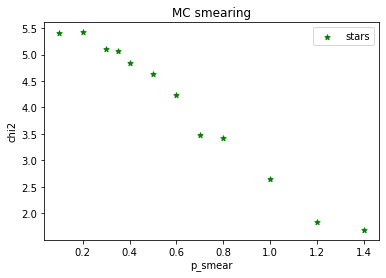

In [49]:
import matplotlib.pyplot as plt

#p_smear = [0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.4]
p_smear = array('d', [0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.4])
#chi2 = [5.40, 5.42, 5.11, 5.07, 4.84, 4.63, 4.23, 3.49, 3.42, 2.65, 1.84, 1.69]
chi2 = array('d', [5.40, 5.42, 5.11, 5.07, 4.84, 4.63, 4.23, 3.49, 3.42, 2.65, 1.84, 1.69])
# plotting points as a scatter plot
plt.scatter(p_smear, chi2, label= "stars", color= "green", marker= "*", s=30)
  
# x-axis label
plt.xlabel('p_smear')
# frequency label
plt.ylabel('chi2')
# plot title
plt.title('MC smearing')
# showing legend
plt.legend()
  
# function to show the plot
plt.show()


In [50]:
#gr = ROOT.TGraphErrors(len(x_val), x_val, y_val, x_val_err, y_val_err)
gr = ROOT.TGraph(len(p_smear), p_smear, chi2)
gr.SetTitle("MC smearing")
gr.GetXaxis().SetTitle("#Delta p/p")
gr.GetYaxis().SetTitle("chi2")
gr.SetMarkerStyle(21)
gr.SetMarkerSize(0.8)
gr.SetLineColor(ROOT.kRed)
gr.SetMarkerColor(ROOT.kGreen)

%jsroot on
c = ROOT.TCanvas()
gr.Draw("AC*")

c.Draw()
c.BuildLegend()

**MM(eK^{+}K^{+}K^{-}) Data Vs MC Fall2018-out-fde Lambda/Sigma signal region not selected**

In [51]:
#h1 = ROOT.RDataFrame("T","mc_rec_fall2018_out_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","mc_rec_fall2018_out_xi_weightdecay_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h2 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data", "data", 25, 0.9, 1.4), "mm_fkpskpkm")#100, 0.0, 2.4
#h1 = ROOT.RDataFrame("T","mc_rec_fall2018_out_xi_weightdecay_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde_v0.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde_v1.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")

#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p1p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p2p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p3p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p4p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p5p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p6p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p7p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p8p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p2p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p4p_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 25,100, 0.0, 2.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 0.0, 2.4), "mm_fkpskpkm")
h2 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data", "data", 100, 0.0, 2.4), "mm_fkpskpkm")
h1.Scale(1/h1.Integral())
h2.Scale(1/h2.Integral())
h1.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
h1.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
h1.SetMarkerStyle(21)
h1.SetMarkerSize(0.5)
h2.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
h2.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
h2.SetMarkerStyle(25)
h2.SetMarkerSize(0.5)
h1.GetXaxis().SetTitleSize(0.05)
h1.GetYaxis().SetTitleSize(0.05)
h1.GetXaxis().SetTitleOffset(0.9)
#h1.GetYaxis().SetTitleOffset(0.9)
h2.GetXaxis().SetTitleSize(0.05)
h2.GetYaxis().SetTitleSize(0.05)
h2.GetXaxis().SetTitleOffset(0.9)
#h.GetYaxis().SetTitleOffset(0.9)

# mm(eK+K+) comparison from simulation and data within 3-sigma cut on mm(eK+K+K-)
#h_xi_mc = ROOT.RDataFrame("T","mc_rec_fall2018_out_xi_weightdecay_fde.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde_v0.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp") #smeared p of two K+s
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde_v1.root").Filter("1.0675<=mm_fkpskpkm && mm_fkpskpkm<=1.2481").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp") #smeared p of all particles

#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p1p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p2p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p3p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p4p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p5p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p6p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p7p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared0p8p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p2p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared1p4p_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
#h_xi_mc = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde.root").Histo1D(("mc-im", "mc-im", 50, 1.5, 3.5), "mm_fkpskp")
h_xi_mc.Scale(1/h_xi_mc.Integral())
#h_xi_mc.Scale(1/h_xi_mc.Integral(), "width")
h_xi_mc.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_xi_mc.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h_xi_mc.SetMarkerStyle(21)
h_xi_mc.SetMarkerSize(0.5)
h_xi_mc.GetXaxis().SetTitleSize(0.05)
h_xi_mc.GetYaxis().SetTitleSize(0.05)
h_xi_mc.GetXaxis().SetTitleOffset(0.9)
#h_xi_mc.GetYaxis().SetTitleOffset(0.9)

h_xi_data = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data-im", "data-im", 50, 1.5, 3.5), "mm_fkpskp")
h_xi_data.Scale(1/h_xi_data.Integral())
#h_xi_data.Scale(1/h_xi_data.Integral(), "width")
h_xi_data.SetMarkerStyle(25)
h_xi_data.SetMarkerSize(0.5)
h_xi_data.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h_xi_data.GetYaxis().SetTitle("Counts/40 MeV/c^{2}")
h_xi_data.GetXaxis().SetTitleSize(0.05)
h_xi_data.GetYaxis().SetTitleSize(0.05)
h_xi_data.GetXaxis().SetTitleOffset(0.9)
#h_xi_data.GetYaxis().SetTitleOffset(0.9)

print(f"Integral of 3Kaon MM from data and mc::, {h2.Integral()} and {h1.Integral()}")
gof_test = 0.0
for i in range(h1.GetNbinsX()):
    #print(f"bin no. {i+1} has normalized data, {h2.GetBinContent(i+1)} and normalized MC, {h1.GetBinContent(i+1)}")
    data = h2.GetBinContent(i+1)
    mc = h1.GetBinContent(i+1)
    if data>0 and mc>0:
         #gof_test = math.pow(mc-data, 2)/math.pow(data, 2)
        gof_test = math.pow(mc-data, 2)*10000
            
print(f"Sum of squares (*10000):: {gof_test:.2f}")

%jsroot on
c = ROOT.TCanvas()
c.Divide(1,2)
c.cd(1)
#h2.Draw("HIST")
h2.Draw("HISTE")
h2.SetTitle("MM(eK^{+}K^{+}K^{-})")
#h1.GetYaxis().SetRangeUser(0, 0.3)
h2.SetLineColor(ROOT.kBlue)
h1.Draw("SAME")
h1.SetLineColor(ROOT.kRed)

t1 = ROOT.TLatex(.94, 0.15, f"10000*#sum S^2 = {gof_test:0.2f}")
t1.Draw()
legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetHeader("MC Vs data","C") # option "C" allows to center the header
legend.AddEntry("mc-rec","mc","lpe")
legend.AddEntry("data","data-fall2018-out-fde","f")
legend.Draw()
#c.Draw()

c.cd(2)
h_xi_mc.Draw()
h_xi_mc.SetTitle("MM(eK^{+}K^{+})")
h_xi_mc.SetLineColor(ROOT.kRed)
h_xi_mc.GetYaxis().SetRangeUser(0, 0.12)
#h_xi_data.Draw("SAMEHIST")
h_xi_data.Draw("SAMEE")
h_xi_data.SetLineColor(ROOT.kBlue)
#h_im1.Scale(1/h_im1.Integral())
#h_im1.Draw("SAME")
legend1 = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend1.SetHeader("MC Vs data","C") # option "C" allows to center the header
legend1.AddEntry("mc-im","mc","lpe")
legend1.AddEntry("data-im","data-fall2018-out-fde","f")#lpe
legend1.Draw()

c.Draw()



Integral of 3Kaon MM from data and mc::, 1.0000000000000007 and 0.9999999999999998
Sum of squares (*10000):: 0.01


**MM(eK^{+}K^{+}K^{-}) Data Vs MC Fall2018-out-fde Xi decay through Lambda channel only**

In [52]:
h1 = ROOT.RDataFrame("T","mc_rec_fall2018_out_lamdecay_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
h2 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data", "data", 25, 0.9, 1.4), "mm_fkpskpkm")#100, 0.0, 2.4
h1.Scale(1/h1.Integral())
h2.Scale(1/h2.Integral())
h1.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
h1.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
h1.SetMarkerStyle(21)
h1.SetMarkerSize(0.5)
h2.SetMarkerStyle(25)
h2.SetMarkerSize(0.5)

%jsroot on
c = ROOT.TCanvas()
h1.Draw()
h1.SetTitle("MM(eK^{+}K^{+}K^{-})")
h1.SetLineColor(ROOT.kRed)
h2.Draw("SAME")
h2.SetLineColor(ROOT.kBlue)
c.Draw()

legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetHeader("MC Vs data","C"); # option "C" allows to center the header
legend.AddEntry("mc-gen","mc-gen","lpe");
legend.AddEntry("data","data-fall2018-out","lpe");
legend.Draw();

**MM(eK^{+}K^{+}K^{-}) Data Vs MC Fall2018-out-fde Xi decay through Sigma channel only**

In [53]:
h1 = ROOT.RDataFrame("T","mc_rec_fall2018_out_sigdecay_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
h2 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data", "data", 25, 0.9, 1.4), "mm_fkpskpkm")#100, 0.0, 2.4
h1.Scale(1/h1.Integral())
h2.Scale(1/h2.Integral())
h1.GetXaxis().SetTitle("MM(eK^{+}K^{+}K^{-}) [GeV/c^{2}]")
h1.GetYaxis().SetTitle("Counts/10 MeV/c^{2}")
h1.SetMarkerStyle(21)
h1.SetMarkerSize(0.5)
h2.SetMarkerStyle(25)
h2.SetMarkerSize(0.5)

%jsroot on
c = ROOT.TCanvas()
h1.Draw()
h1.SetTitle("MM(eK^{+}K^{+}K^{-})")
h1.SetLineColor(ROOT.kRed)
h2.Draw("SAME")
h2.SetLineColor(ROOT.kBlue)
c.Draw()

legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetHeader("MC Vs data","C"); # option "C" allows to center the header
legend.AddEntry("mc-gen","mc-gen","lpe");
legend.AddEntry("data","data-fall2018-out","lpe");
legend.Draw();

In [54]:
h1 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data","data", 100, 0.0, 2.4), "mm_fkpskpkm") #100, 0.0, 2.4
%jsroot on
c = ROOT.TCanvas()
h1.Draw("E")
h1.SetTitle("MM(eK^{+}K^{+}K^{-})")
h1.SetLineColor(ROOT.kRed)
h1.SetMarkerStyle(21)
h1.SetMarkerSize(0.8)
h1.SetStats(0)

# fit resonance
h1_fitFcn = ROOT.TF1('h1_fitFcn', ROOT.fitGaus, 0.0, 2.4, 5)
h1_fitFcn.SetLineWidth(3)
h1_fitFcn.SetLineColor(ROOT.kMagenta)#kMagenta#kBlue
h1_fitFcn.SetParameter(0, h1.GetBinContent(h1.GetMaximumBin())) #peak
h1_fitFcn.SetParameter(1, h1.GetBinCenter(h1.GetMaximumBin())) #mean
h1_fitFcn.SetParameter(2, 0.015) #sigma
h1_fitFcn.SetParameter(3, 0.6) #p0
h1_fitFcn.SetParameter(4, 0.6) #p1

h1.Fit("h1_fitFcn", "EV","",0.9,1.3) # Global Fit
#h1.Fit("h1_fitFcn","V+","ep");

#improve the picture:
backFcn = ROOT.TF1("backFcn", ROOT.background, 0.9, 1.3, 2)
backFcn.SetParameters(h1_fitFcn.GetParameter(3), h1_fitFcn.GetParameter(4))
backFcn.SetLineColor(ROOT.kRed);
signalFcn = ROOT.TF1("signalFcn", ROOT.GaussianPeak, 0.9, 1.3, 3)
signalFcn.SetParameters(h1_fitFcn.GetParameter(0), h1_fitFcn.GetParameter(1), h1_fitFcn.GetParameter(2))
signalFcn.SetLineColor(ROOT.kBlue)#ROOT.kGreen
#signalFcn.SetNpx(500)

backFcn.Draw("same")
signalFcn.Draw("same")

#Intergal from (3sigma)signal and background function
factor = 3

signalIntg = signalFcn.Integral(h1_fitFcn.GetParameter(1)-factor*h1_fitFcn.GetParameter(2), h1_fitFcn.GetParameter(1)+factor*h1_fitFcn.GetParameter(2))
backgroungIntegral = backFcn.Integral(h1_fitFcn.GetParameter(1)-factor*h1_fitFcn.GetParameter(2), h1_fitFcn.GetParameter(1)+factor*h1_fitFcn.GetParameter(2))
#Yield per bin width
binw = h1.GetBinWidth(1)
sigYield = signalIntg/(binw*1000)
print(f"Signal {signalIntg:f}, Background {backgroungIntegral:f} in Bin width of {binw:f} and hence Yield per bin is {sigYield:}" )

c.Draw()

legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetTextFont(72)
legend.SetTextSize(0.04)
legend.SetHeader("Fall2018out_fde","C") # option "C" allows to center the header
legend.AddEntry("data","Data","lpe")
legend.AddEntry("backFcn", "Backgroung Fit","l")
legend.AddEntry("signalFcn", "Signal Fit","l")
legend.AddEntry("h1_fitFcn","Global Fit","l") #legend->AddEntry("f1","Function abs(#frac{sin(x)}{x})","l");
#legend.AddEntry("allcorn","all corn","l"); #legend->AddEntry("gr","Graph with error bars","lep");
legend.Draw();


Signal 4.275380, Background 2.296652 in Bin width of 0.024000 and hence Yield per bin is 0.1781408401243568
 **********
 **    1 **SET PRINT           2
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 p0           8.00000e+01  2.40000e+01     no limits
     2 p1           1.14000e+00  3.42000e-01     no limits
     3 p2           1.50000e-02  4.50000e-03     no limits
     4 p3           6.00000e-01  1.80000e-01     no limits
     5 p4           6.00000e-01  1.80000e-01     no limits
 **********
 **    3 **SET ERR           1
 **********
 **********
 **    4 **SET PRINT           2
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1625        0.01
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENC

Info in <TMinuitMinimizer::Minimize>: Finished to run MIGRAD - status 0
Info in <TMinuitMinimizer::Minimize>: Finished to run HESSE - status 0


**MM(eK+K+) from generated events (Blue), Reconstructed Events (Red) from the simulation, and Real data events (Green) from Fall2018/Spring2019 RGA data set** 

In [55]:
#h1 = ROOT.RDataFrame("T","mc_gen_fall2018_out_fde.root").Histo1D(("mc-gen", "mc-gen", 100, 1.5, 3.5), "mm_fkpskp")
#h2 = ROOT.RDataFrame("T","mc_rec_fall2018_out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 1.5, 3.5), "mm_fkpskp")
h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/gen_xi_mc_fall2018out_fde.root").Histo1D(("mc-gen", "mc-gen", 50, 1.4, 2.4), "mm_fkpskp")
h2 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 50, 1.4, 2.4), "mm_fkpskp")
#h3 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data", "data", 50, 1.5, 3.5), "mm_fkpskp")
#100, 1.5, 3.5 #50, 1.5, 3.5#25, 1.4, 2.4#50, 1.4, 2.4
h1.GetXaxis().SetTitle("MM(eK^{+}K^{+}) [GeV/c^{2}]")
h1.GetYaxis().SetTitle("Counts/20 MeV/c^{2}")
#h1.GetXaxis().SetLabelSize(0.05)
#h1.GetYaxis().SetLabelSize(0.05)
h1.GetXaxis().SetTitleSize(0.05)
h1.GetYaxis().SetTitleSize(0.05)
h1.GetXaxis().SetTitleOffset(0.9)
#h1.GetYaxis().SetTitleOffset(0.9)


%jsroot on
c = ROOT.TCanvas()
c.Divide(1,2)
c.cd(1)
ROOT.gStyle.SetOptStat(0)
h1.Draw()
h1.SetTitle("MM(eK^{+}K^{+})")
h1.SetLineColor(ROOT.kBlue)
#h1.SetFillColor(ROOT.kBlue)
h1.GetXaxis().SetRangeUser(1.55, 2.29)
h2.Draw("SAME")
h2.SetLineColor(ROOT.kRed)
#h2.SetFillColor(ROOT.kRed)
#h3.Draw("SAME")
#h3.SetLineColor(ROOT.kMagenta)#ROOT.kGreen

legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetHeader("mc-vs-data-fall2018out-fde","C"); # option "C" allows to center the header
legend.AddEntry("mc-gen","mc-gen","l");
legend.AddEntry("mc-rec","mc-rec","l"); #legend->AddEntry("f1","Function abs(#frac{sin(x)}{x})","l");
#legend.AddEntry("data","data","l"); #legend->AddEntry("gr","Graph with error bars","lep");
legend.Draw();


#Efficiency graph 
x_values = array('d')
x_value_err  = array('d')
y_values = array('d')
y_value_err = array('d')

for i in range(h1.GetNbinsX()):
    #print("i = ", i,"Bin no", h1.GetNbinsX())
    gen = h1.GetBinContent(i+1)
    rec = h2.GetBinContent(i+1)
    #print("Bin no", i+1,"gen = ", gen,"rec = ", rec)
    if gen>0 and rec>0: #and rec>0
        eff = rec/gen;
        err = math.sqrt((eff*(1-eff))/gen) #sqrt((e*(1-e))/N)#gen
        x_values.append(h1.GetXaxis().GetBinCenter(i+1))
        x_value_err.append(0.0)
        y_values.append(eff)
        y_value_err.append(err)
        
        #print("Bin no", i+1,"efficiency = ", eff,"error in eff = ", err)
           
graph = ROOT.TGraphErrors(len(x_values), x_values, y_values, x_value_err, y_value_err)
#graph.SetMarkerStyle(21)
#graph.SetLineWidth(1)
graph.GetXaxis().SetTitleSize(0.05)
graph.GetYaxis().SetTitleSize(0.05)
graph.GetXaxis().SetTitleOffset(0.9)
#graph.GetXaxis().SetRangeUser(1.4, 2.4)
#graph.GetYaxis().SetRangeUser(0.0005, 0.0014)
graph.SetTitle("#epsilon")
graph.GetXaxis().SetTitle("Mx(ep#rightarroweK^{+}K^{+}X) [GeV/c^{2}]")
graph.GetYaxis().SetTitle("efficiency/(20 MeV/c^{2}) bin")

c.cd(2)
graph.Draw("CP")#AC*#CP#ALP#Psame
gr_legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
gr_legend.SetHeader("efficiency-fall2018out-fde","C")
gr_legend.Draw()

c.Draw()


In [56]:

#h1 = ROOT.RDataFrame("T","mc_gen_fall2018_out_fde.root").Histo1D(("mc-gen", "mc-gen", 100, 1.5, 3.5), "mm_fkpskp")
#h2 = ROOT.RDataFrame("T","mc_rec_fall2018_out_fde.root").Histo1D(("mc-rec", "mc-rec", 100, 1.5, 3.5), "mm_fkpskp")
h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/gen_xi_mc_fall2018out_fde.root").Histo1D(("mc-gen", "mc-gen", 50, 1.5, 3.5), "mm_fkpskp")
h2 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 50, 1.5, 3.5), "mm_fkpskp")

#h3 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data", "data", 100, 1.5, 3.5), "mm_fkpskp")

x_values = array('d')
x_value_err  = array('d')
y_values = array('d')
y_value_err = array('d')

for i in range(h1.GetNbinsX()):
    #print("i = ", i,"Bin no", h1.GetNbinsX())
    gen = h1.GetBinContent(i+1)
    rec = h2.GetBinContent(i+1)
    #print("Bin no", i+1,"gen = ", gen,"rec = ", rec)
    if gen>0 and rec>0: #and rec>0
        eff = rec/gen;
        err = math.sqrt((eff*(1-eff))/gen) #sqrt((e*(1-e))/N)#gen
        x_values.append(h1.GetXaxis().GetBinCenter(i+1))
        x_value_err.append(0.0)
        y_values.append(eff)
        y_value_err.append(err)
        
        #print("Bin no", i+1,"efficiency = ", eff,"error in eff = ", err)
           
graph = ROOT.TGraphErrors(len(x_values), x_values, y_values, x_value_err, y_value_err) 
#g = ROOT.TGraphAsymmErrors()
#g.BayesDivide(h2.GetPtr(), h1.GetPtr())
#g.Divide(h2.GetPtr(), h1.GetPtr(), "pois")
graph.SetTitle("efficiency")
%jsroot on
c = ROOT.TCanvas()
graph.Draw("CP")#AC*#CP#ALP
#g.Draw("SAMECP")
c.Draw()
legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetHeader("efficiency-fall2018out-fde","C")
legend.Draw()

**MM(eK+K+K-)  EdGen-Generated vs GEANT4-Reconstructed**

In [57]:
h1 = ROOT.RDataFrame("T","mc_gen_fall2018_out_fde.root").Histo1D(("mc-gen", "mc-gen", 200, 1.09, 1.23),"mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","mc_gen_fall2018_in_fte.root").Range(10000).Histo1D(("mc-gen", "mc-gen", 25, 0.9, 1.4),"mm_fkpskpkm")
h2 = ROOT.RDataFrame("T","mc_rec_fall2018_out_fde.root").Histo1D(("mc-rec", "mc-rec", 200, 1.09, 1.23),"mm_fkpskpkm")
#400, 0, 4#25, 0.9, 1.4
%jsroot on
c = ROOT.TCanvas()
ROOT.gStyle.SetOptStat(0)
h1.Draw()
h1.SetTitle("MM(eK^{+}K^{+}K^{-})")
h1.SetLineColor(ROOT.kBlue)
h2.Draw("SAME")
h2.SetLineColor(ROOT.kRed)
c.Draw()

legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetHeader("MC genVsrecon","C"); # option "C" allows to center the header
legend.AddEntry("mc-gen","mc-gen","l");
legend.AddEntry("mc-rec","mc-rec","l");
legend.Draw();

**MM(eK+K+K-)  check weather we need fte correction to analyze Simulated data**

**MM(eK+K+K-) Simulation Vs Data Fall2018-out**

In [58]:
#h1 = ROOT.RDataFrame("T","mc_rec_fall2018_out_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
#h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_smeared_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
h1 = ROOT.RDataFrame("T","../simu_prod/xi_mc_fall2018out_fde/plot/rec_xi_mc_fall2018out_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
h2 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data", "data", 25, 0.9, 1.4), "mm_fkpskpkm")#100, 0.0, 2.4
h1.Scale(1/h1.Integral())
h2.Scale(1/h2.Integral())

%jsroot on
ROOT.gStyle.SetOptStat(00000)
c = ROOT.TCanvas()
h1.Draw()
h1.SetTitle("MM(eK^{+}K^{+}K^{-})")
h1.SetLineColor(ROOT.kRed)
h2.Draw("SAME")
h2.SetLineColor(ROOT.kGreen)
c.Draw()

legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetHeader("MC Vs data","C"); # option "C" allows to center the header
legend.AddEntry("mc-rec","mc-rec","l");
legend.AddEntry("data","data-fall2018-in","l");
legend.Draw();

**MM(eK+K+K-) Fall2018-in vs simulation**

In [59]:
h1 = ROOT.RDataFrame("T","mc_rec_fall2018_out_sigdecay_fde.root").Histo1D(("mc-rec", "mc-rec", 25, 0.9, 1.4), "mm_fkpskpkm")
h2 = ROOT.RDataFrame("T","data_fall2018_out_fde.root").Histo1D(("data", "data", 25, 0.9, 1.4), "mm_fkpskpkm")
h1.Scale(1/h1.Integral())
h2.Scale(1/h2.Integral())

%jsroot on
c = ROOT.TCanvas()
h1.Draw()
h1.SetTitle("MM(eK^{+}K^{+}K^{-})")
h1.SetLineColor(ROOT.kRed)
h2.Draw("SAME")
h2.SetLineColor(ROOT.kGreen)
c.Draw()

legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetHeader("MC Vs data","C"); # option "C" allows to center the header
legend.AddEntry("mc-gen","mc-gen","l");
legend.AddEntry("data","data-fall2018-in","l");
legend.Draw();

In [60]:
ROOT.EnableImplicitMT()
ROOT.gStyle.SetOptStat(00000)
gen_mctree = "T"
rec_mctree = "T"
data_file = "data_fall2018_out_fde.root"
gen_mcfile = "mc_gen_fall2018_out_fde.root"
#rec_mcfile = "mc_rec_fall2018_out_fde.root"
rec_mcfile = "mc_rec_fall2018_out_lamdecay_fde.root"
df = ROOT.RDataFrame(data_tree, data_file)
genmcdf = ROOT.RDataFrame(gen_mctree, gen_mcfile)
recmcdf = ROOT.RDataFrame(rec_mctree, rec_mcfile)

h1 = recmcdf.Histo1D(("rec_mm_fkpskpkm", "rec_mm_fkpskpkm", 25, 0.9, 1.4), "mm_fkpskpkm") # 25, 0.0, 2.4
h1.SetTitle("MM(eK^{+}K^{+}K^{-})")
h2 = df.Histo1D(("data_mm_fkpskpkm", "data_mm_fkpskpkm", 25, 0.9, 1.4), "mm_fkpskpkm") # 25, 0.9, 1.4 #200, 0.0, 2.4
h1.Scale(1/h1.Integral())
h2.Scale(1/h2.Integral())


#ROOT.RDF.RunGraphs((h1, h2))
h1.SetLineColor(ROOT.kRed)
%jsroot on
c = ROOT.TCanvas()
h1.Draw()
c.Draw()
h2.Draw("SAME")
h2.SetLineColor(ROOT.kGreen)
c.Draw()

legend = ROOT.TLegend(0.9,0.8,0.7,0.9)#legend = ROOT.TLegend()
legend.SetTextFont(72)
legend.SetTextSize(0.04)
legend.SetHeader("fall2018_out_fde","C") 
legend.AddEntry("rec_mm_fkpskpkm","MC","lpe")
legend.AddEntry("data_mm_fkpskpkm","DATA","lpe")
legend.Draw()

In [52]:
data_tree = "T"
gen_mctree = "T"
rec_mctree = "T"
data_file = "data_spring2019_in_fde.root"#"data_fall2018_out_fde.root"
gen_mcfile = "mc_gen_fall2018_out_fde.root"
rec_mcfile = "mc_rec_fall2018_out_fde.root"
df = ROOT.RDataFrame(data_tree, data_file)
genmcdf = ROOT.RDataFrame(gen_mctree, gen_mcfile)
recmcdf = ROOT.RDataFrame(rec_mctree, rec_mcfile)
#quick check
%jsroot on
c = ROOT.TCanvas()
"""
h = df.Histo1D("runnum")
h = df.Histo1D("evnum")
h = df.Histo1D("beam_e")
"""
#h=df.Filter("runnum<6000").Define("q2spring2019", "q2").Histo1D("q2")
#h=df.Histo1D(("h_q2", "h_q2", 100, 0, 7), "q2")
#h=df.Filter("beam_e==10.604f").Define("q2fall2018in", "q2").Histo1D(("h_q2", "h_q2", 100, 0.00001, 0.5), "q2") #beam_e==10.1998f#beam_e==10.604f
#h=df.Filter("q2", "beam_e > 10.6").Histo1D("q2")#h = df.Histo1D("q2") #h=df.Filter("q2", "beam_e < 10.6").Histo1D("q2")
"""
h = df.Histo1D("nu")
h = df.Histo1D("x")
h = df.Histo1D("W")
h = df.Histo1D("e_px")
h = df.Histo1D("e_py")
h = df.Histo1D("e_pz")
h = df.Histo1D("e_p")
h = df.Histo1D("e_e")
h = df.Histo1D("e_vx")
h = df.Histo1D("e_vy")
h = df.Histo1D("e_vz")
h = df.Histo1D("e_theta")
h = df.Histo1D("e_phi")
h = df.Histo1D("fkp_px")
h = df.Histo1D("fkp_py")
h = df.Histo1D("fkp_pz")
h = df.Histo1D("fkp_p")
h = df.Histo1D("fkp_e")
h = df.Histo1D("fkp_vx")
h = df.Histo1D("fkp_vy")
h = df.Histo1D("fkp_vz")
h = df.Histo1D("fkp_theta")
h = df.Histo1D("fkp_phi")
h = df.Histo1D("skp_px")
h = df.Histo1D("skp_py")
h = df.Histo1D("skp_pz")
h = df.Histo1D("skp_p")
h = df.Histo1D("skp_e")
h = df.Histo1D("skp_vx")
h = df.Histo1D("skp_vy")
h = df.Histo1D("skp_vz")
h = df.Histo1D("skp_theta")
h = df.Histo1D("skp_phi")
h = df.Histo1D("km_px")
h = df.Histo1D("km_py")
h = df.Histo1D("km_pz")
h = df.Histo1D("km_p")
h = df.Histo1D("km_e")
h = df.Histo1D("km_vx")
h = df.Histo1D("km_vy")
h = df.Histo1D("km_vz")
h = df.Histo1D("km_theta")
h = df.Histo1D("km_phi")
h = df.Histo1D("m_fkpskp")
h = df.Histo1D("m_fkpkm")
h = df.Histo1D("m_skpkm")
h = df.Histo1D("m_fkpskpkm")
h = df.Histo1D("mm_e")
h = df.Histo1D("mm_fkp")
h = df.Histo1D("mm_skp")
h = df.Histo1D("mm_km")
h = df.Histo1D("mm_fkpskp")
h = df.Histo1D("mm_fkpkm")
h = df.Histo1D("mm_skpkm")
h = df.Histo1D("mm_fkpskpkm")
h = df.Histo1D("mm_fkpaspipskpkm")
h = df.Histo1D("mm_fkpskpaspipkm")
h = df.Histo1D("mm_fkpskpkmaspim")
h = df.Histo1D("mm_fkpaspipskpaspipkm")
h = df.Histo1D("mm_fkpaspipskpkmaspim")
h = df.Histo1D("mm_fkpskpaspipkmaspim")
h = df.Histo1D("mm_fkpaspipskpaspipkmaspim")
"""
#h = df.Histo1D("mm_fkpaspipskpkm")
#h = df.Histo1D("mm_fkpskpaspipkm")
h = df.Histo1D("mm_fkpskpkmaspim")

h.Draw()
c.Draw()

**To check pions misidentified as kaons in my events**

In [62]:
data_tree = "T"
gen_mctree = "T"
rec_mctree = "T"
data_file = "data_fall2018_out_fde.root"
gen_mcfile = "mc_gen_fall2018_out_fde.root"
rec_mcfile = "mc_rec_fall2018_out_fde.root"
df = ROOT.RDataFrame(data_tree, data_file)
genmcdf = ROOT.RDataFrame(gen_mctree, gen_mcfile)
recmcdf = ROOT.RDataFrame(rec_mctree, rec_mcfile)
#quick 2D histos with RDataFrame check
#h = df.Histo1D("mm_fkpskpkm", "mm_fkpaspipskpkm")
h = df.Histo2D(("hxy", "hxy", 25, 0.9, 1.4, 25, 0.9, 1.4), "mm_fkpskpkm", "mm_fkpaspipskpkm")
#h = df.Histo2D(("hxy", "hxy", 25, 0.9, 1.4, 25, 0.9, 1.4), "mm_fkpskpkm", "mm_fkpskpaspipkm")
#h = df.Histo2D(("hxy", "hxy", 25, 0.9, 1.4, 25, 0.9, 1.4), "mm_fkpskpkm", "mm_fkpskpkmaspim")
#h = df.Histo2D(("hxy", "hxy", 25, 0.9, 1.4, 25, 0.9, 1.4), "mm_fkpskpkm", "mm_fkpaspipskpaspipkm")
#h = df.Histo2D(("hxy", "hxy", 25, 0.9, 1.4, 25, 0.9, 1.4), "mm_fkpskpkm", "mm_fkpaspipskpkmaspim")
#h = df.Histo2D(("hxy", "hxy", 25, 0.9, 1.4, 25, 0.9, 1.4), "mm_fkpskpkm", "mm_fkpskpkmaspim")
#h = df.Histo2D(("hxy", "hxy", 25, 0.9, 1.4, 25, 1.1, 1.6), "mm_fkpskpkm", "mm_fkpaspipskpaspipkmaspim")
%jsroot on
c = ROOT.TCanvas()
h.Draw("colz")#ARR,BOX,COL,COLZ,CONT,LEGO
c.Draw()

In [63]:
%jsroot on
c = ROOT.TCanvas()
h = df.Histo1D(("h0","h0",400, 0, 4), "mm_fkpskpkm")
h.Draw()
c.Draw()